In [1]:
#basic imports and ipython setup
import matplotlib.pyplot as plt
import numpy as np

import os.path

from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm

from tqdm import tqdm

import pandas as pd
from MCEq.geometry.density_profiles import GeneralizedTarget

import matplotlib as mpl
from cycler import cycler

In [2]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

## Overview

In [3]:
# Phi0 : Primary CR Intensity models over time
# axis0 : Primary model (Energy spectrum & Time variance)
# axis1 : Primary Energy
# axis2 : time (past -> present)

# lambda_dt : Fraction of 14C which survives to present * Time bin width
# axis0 : N/A
# axis1 : N/A
# axis2 : time (past -> present)

# MU : Longitudinal Muon Spectrum matrix
# axis0 : Interaction model (Atmospheric Interaction model, Underground Interatction model, Density profile)
# axis1 : depth
# axis2 : Muon Energy
# axis3 : Primary Energy

# INT_neg : Negative Capture production matrix = -d/dh sum_E(MU_neg) * f_C * f_D * f_star /100 * 60 * 60 * 24 * 365.25
# axis0 : Interaction model
# axis1 : depth
# axis2 : Primary Energy

# INT_fast : Fast Interaction production matrix = sum_E(MU * E^alpha) * sigma_0 * N /100 * 60 * 60 * 24 * 365.25
# axis0 : Interaction model
# axis1 : depth
# axis2 : Primary Energy

# INT : 14C Production matrices = [INT_neg, INT_fast].swapaxes(0,-3) + axis1 + axis2
# axis0 : N/A
# axis1 : Interaction model
# axis2 : production mode
# axis3 : depth
# axis4 : Primary Energy

# P_Rates : 14C Production rates = INT @ Phi0
# axis0 : Primary model
# axis1 : Interaction model
# axis2 : production mode
# axis3 : depth
# axis4 : time (past -> present)

# C : 14C concentration by mode = diag_sum(INT @ (Phi0 * lambda_dt)) = diag_sum(P_Rates * lambda_dt)
# axis0 : Primary model
# axis1 : Interaction model
# axis2 : production mode
# axis3 : depth

# F : 14CO production factors
# axis0 : f_factor model
# axis1 : production mode

# CO : 14CO concentration profiles = F @ C
# axis0 : Primary model
# axis1 : Interaction model
# axis2 : f_factor model
# axis3 : depth

# core_mat : Matrix for averaging over ice core sample ranges
# axis0 : depth
# axis1 : sample depth

# CO_core : 14CO ice core predicted results = CO @ core_mat
# axis0 : Primary model
# axis1 : Interaction model
# axis2 : f_factor model
# axis3 : sample depth

## MCEq

In [4]:
def surface_flux(cosTH, primary_model = (pm.GlobalSplineFitBeta, None), interaction_model = 'DPMJETIII191', density_model = ('CORSIKA',('SouthPole', 'December')), elev = 3120, sol=True, use_tqdm=False):
    """ Sets up and runs an atmospheric MCEq calculation
    
    Parameters
    -----------
    cosTH : float bounded by (0., 1.]
        cosine of zenith angle
    
    primary_model : tuple
        MCEq primary model
        
    interaction_model : string
        MCEq interaction model
    
    density_model : tuple
        MCEq density model
        
    elev : int or float
        surface elevation in meters
        
    sol : bool
        Whether or not to solve the MCEq before returning
        
    use_tqdm : bool
        If True, runs a tqdm progress bar during integration
        
        
    Returns
    --------
    mceq : MCEqRun object
        MCEq instance specified by inputs
    """
    # configure MCEq
    import mceq_config as config
    
    config.debug_level = 0
    
    config.h_obs = elev # elevation in (m) of Dome-C
    
    config.enable_default_tracking = False
    
    #density_model = ('CORSIKA',('SouthPole', 'June'))
    #density_model = ('CORSIKA',('SouthPole', 'December'))
    #density_model = ('CORSIKA', ('USStd', None))
    
    config.max_density = 0.001225
    config.dedx_material = 'air'

    # initialize MCEq
    mceq = MCEqRun(
        interaction_model=interaction_model,
        theta_deg = 180*np.arccos(cosTH)/np.pi,
        density_model = density_model,
        #medium=medium,
        primary_model = primary_model,
    )
    
    if sol: # solve MCEq
        #mceq.solve()
        
        solve_mceq(mceq, use_tqdm=use_tqdm)
    
    return mceq

In [5]:
def depth_flux(flux, z, h, cosTH, rho, interaction_model = 'DPMJETIII191', sol=True, use_tqdm=False):
    """ Sets up and runs an underground ice MCEq calculation
    
    Parameters
    -----------
    flux : array of floats, final axis must match mceq._phi0
        incoming particle flux
        
    z : 1d array of floats
        initial depths of target material density bins, in meters
    
    h : 1d array of floats
        grid solution depths, in m.w.e. (hg/cm^2)
    
    cosTH : float bounded by (0., 1.]
        cosine of zenith angle
        
    rho : 1d array of floats, same size as z
        target material densities, in g/cm^3
        
    interaction_model : string
        MCEq interaction model
        
    sol : bool
        Whether or not to solve the MCEq before returning
        
    use_tqdm : bool
        If True, runs a tqdm progress bar during integration
        
        
    Returns
    --------
    mceq : MCEqRun object
        MCEq instance specified by inputs
    """
    # configure MCEq
    import mceq_config as config
    
    config.enable_default_tracking = False
    
    config.debug_level = 0 #2
    
    primary_model = (pm.GlobalSplineFitBeta, None)
    
    medium = 'ice'
    rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)
    
    # setup ice density profile
    target = GeneralizedTarget(len_target=z[-1]*100/cosTH, env_density = rho_ice, env_name = 'ice')
    # manually enter all density layers at once because doing it one-by-one takes forever
    target.mat_list = [[z[i]*100/cosTH, z[i+1]*100/cosTH, rho[i], 'ice'] for i in range(len(z)-1)]
    target._update_variables()
        
    config.max_density = 0.9239
    config.dedx_material = 'ice'
    
    # initialize MCEq
    mceq = MCEqRun(
        interaction_model = interaction_model,
        theta_deg = 0,
        density_model = target,
        medium=medium,
        primary_model = primary_model,
    )

    mceq._phi0 = flux # set initial particle flux
    
    if sol: # solve MCEq
        #mceq.solve(int_grid=h/cosTH*100)
        
        solve_mceq(mceq, int_grid=h/cosTH*100, use_tqdm=use_tqdm)
    
    return mceq

In [6]:
def solve_mceq(mceq, int_grid=None, grid_var='X', use_tqdm=False):
    """ Runs numpy solver of MCEq, zeroing out values below 1e-250
    
    Parameters
    -----------
    mceq : MCEqRun object
        MCEq instance to be solved
    
    int_grid : 1d array of floats or None
        grid solution depths, in cm.w.e (g/cm^2)
    
    grid_var : str
        No idea what this does, just send it into mceq._calculate_integration_path
        
    use_tqdm : bool
        If True, runs a tqdm progress bar during integration
    """
    # Calculation is identical to MCEq numpy solver, except where noted
    
    mceq._calculate_integration_path(int_grid=int_grid, grid_var=grid_var)

    nsteps, dX, rho_inv, grid_idcs = mceq.integration_path
    int_m = mceq.int_m
    dec_m = mceq.dec_m

    dXaccum = 0.
    grid_sol = np.zeros((len(grid_idcs), *np.shape(mceq._phi0))) # grid_sol begins with the right shape, to avoid restructuring
    grid_step = 0

    phc = np.copy(mceq._phi0)
    
    for step in (tqdm(range(nsteps)) if use_tqdm else range(nsteps)): # added option for tqdm progress bar
        phc += (int_m.dot(phc) + dec_m.dot(rho_inv[step] * phc)) * dX[step]
        phc[phc<1e-250] = 0. # exreme low values set to 0, improving efficiency for large slant depths

        if (grid_idcs and grid_step < len(grid_idcs)
                and grid_idcs[grid_step] == step):
            grid_sol[grid_step] = np.copy(phc) # grid_sol no longer appends
            grid_step += 1

    mceq._solution, mceq.grid_sol = phc, grid_sol
    
    return

In [7]:
def flux_matrix_one_ang(particles, z, h, cosTH, rho, interaction_model = 'DPMJETIII191', density_model=('CORSIKA',('SouthPole', 'December')), elev = 3120, surf=True, depth=True):
    """ Solves for the muon spectrum from every possible primary particle energy, at a specific zenith angle
    
    Parameters
    -----------
    particles : 1d array of strings
        Names of primary particles used as input spectrum
        
    z : 1d array of floats
        initial depths of target material density bins, in meters
    
    h : 1d array of floats
        grid solution depths, in m.w.e. (hg/cm^2)
    
    cosTH : float bounded by (0., 1.]
        cosine of zenith angle
        
    rho : 1d array of floats, same size as z
        target material densities, in g/cm^3
        
    interaction_model : string
        MCEq interaction model
        
    elev : int or float
        surface elevation in meters
        
    surf : bool
        if False, skips atmospheric interactions
    
    depth : bool
        if False, skips underground ice interactions
        
    Returns
    --------
    phi_int : array of floats
        Muon spectra produced by primary particles, in #particles /cm^2 /sr /s
        axis0 : depth
        axis1 : muon energy
        axis2 : CR particle & energy
    """
    
    print('Calculating muon flux response at {:.1f} degrees'.format(180*np.arccos(cosTH)/np.pi))
    
    # initialize atmospheric MCEq
    mceq = surface_flux(cosTH, interaction_model=interaction_model, density_model=density_model, elev=elev, sol=False)
    
    pname = mceq.pman.pname2pref # reference for particle names and indices
    
    # range of particle indices used as primaries
    i_range = np.concatenate([np.arange(pname[p].lidx, pname[p].uidx) for p in particles])
    
    # setup 2d matrix of single-source fluxes
    phi0 = np.zeros((len(mceq._phi0), len(i_range))) # empty matrix
    phi0[i_range,np.arange(len(i_range))] = 1. # set flux=1 for a single primary particle energy per spectrum
    # axis0 : all particles & energies
    # axis1 : primary particles & energies
    
    if surf:
        print('Propagating through atmosphere...')
        # solve atmospheric MCEq for surface flux
        mceq._phi0 = phi0
        solve_mceq(mceq, use_tqdm=True)
    else:
        # skip atmospheric calculation
        mceq._solution = phi0
    
    if depth:
        print('Propagating through ice...')
        # solve in-ice MCEq for underground flux

        mceq_fin = depth_flux(mceq._solution, z, h, cosTH, rho, interaction_model = interaction_model, use_tqdm=True)
        
        print('Retrieving Muon Flux...')
        
        # calculate underground muon flux
        phi_sum = np.sum([mceq_fin.grid_sol[:, pname[mu].lidx:pname[mu].uidx] for mu in ['mu+_l', 'mu+', 'mu+_r', 'mu-_l', 'mu-', 'mu-_r']], axis=0) # sum all muon intensities
        phi_int = phi_sum * mceq_fin._energy_grid.w.reshape((1,-1,1)) # multiply muon intensity by energy bin width
    else:
        # skip in-ice calculation
        
        print('Retrieving Muon Flux...')
        
        # calculate surface flux
        phi_sum = np.sum([mceq._solution[pname[mu].lidx:pname[mu].uidx] for mu in ['mu+_l', 'mu+', 'mu+_r', 'mu-_l', 'mu-', 'mu-_r']], axis=0) # sum all muon intensities
        phi_int = phi_sum * mceq._energy_grid.w.reshape((-1,1)) # multiply muon intensity by energy bin width
        
    return phi_int

In [8]:
def flux_matrix_all(particles, z, h, cosTH, dcosTH, rho, interaction_model = 'DPMJETIII191', density_model=('CORSIKA',('SouthPole', 'December')), elev = 3120, surf=True, depth=True):
    """ Solves for the muon spectrum from every possible primary particle energy, integrated over a range of zenith angles
    
    Parameters
    -----------
    particles : 1d array of strings
        Names of primary particles used as input spectrum
        
    z : 1d array of floats
        initial depths of target material density bins, in meters
    
    h : 1d array of floats
        grid solution depths, in m.w.e. (hg/cm^2)
    
    cosTH : 1d array of floats
        cosine of zenith angle
        
    dcosTH : float or 1d array of floats (same size as cosTH)
        bin width of cosTH
        
    rho : 1d array of floats, same size as z
        target material densities, in g/cm^3
        
    interaction_model : string
        MCEq interaction model
        
    elev : int or float
        surface elevation in meters
        
    surf : bool
        if False, skips atmospheric interactions
    
    depth : bool
        if False, skips underground ice interactions and returns surface spectrum without integrating over cosTH
        
    Returns
    --------
    phi_int : array of floats
        Muon spectra produced by primary particles, in #particles /cm^2 /sr /s
        axis0 : depth
        axis1 : muon energy
        axis2 : CR particle & energy
    """
    
    if not (surf and depth):
        # calculate surface spectrum over cosTH range
        return np.array([flux_matrix_one_ang(particles, z, h, cth, rho, interaction_model = interaction_model, density_model=density_model, elev = elev, surf=surf, depth=depth) for cth in cosTH])
    else:
        # integrate longitudinal muon spectrum over cosTH range
        phi_mu_tot = flux_matrix_one_ang(particles, z, h, cosTH[0], rho, interaction_model = interaction_model, density_model=density_model, elev = elev, surf=surf, depth=depth)
        phi_mu_tot *= dcosTH
        for i in range(1,len(cosTH)):
            phi_mu_tot += flux_matrix_one_ang(particles, z, h, cosTH[i], rho, interaction_model = interaction_model, density_model=density_model, elev = elev, surf=surf, depth=depth) * dcosTH
    
    return 2*np.pi*phi_mu_tot

## Dome-C Ice Profile



In [9]:
age_scale_file = 'DomeC_age_scale_Apr2023.csv' # relationship between age and depth of ice at Dome-C
ice_eq_depth_file = 'Real_vs_ice_eq_depth.csv' # relationship bewteen ice-equivalent-depth and real-depth at Dome-C

# read age-scale file
age_scale = pd.read_csv(age_scale_file)
ages = np.array(age_scale['ages']) # years
depths_real = np.array(age_scale['depths_real']) # meters

# read ice-eq-depth file
ice_eq_depth = pd.read_csv(ice_eq_depth_file)
real_z = ice_eq_depth['z'] # meters
ice_eq_z = ice_eq_depth['ice_eq_z'] # meters (ice-eq) aka mass-depth / ice density

In [10]:
rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)

def z_to_t(z): # convert real depth to age
    return np.interp(z, depths_real, ages)

def t_to_z(t): # convert age to real depth
    return np.interp(t, ages, depths_real)

def z_to_h(z): # convert real depth to mass depth
    return np.interp(z, real_z, ice_eq_z)*rho_ice

def h_to_z(h): # convert mass depth to real depth
    return np.interp(h/rho_ice, ice_eq_z, real_z)

def h_to_t(h): # convert mass depth to age
    return z_to_t(h_to_z(h/rho_ice))

def t_to_h(t): # convert age to mass depth
    return z_to_h(t_to_z(t))*rho_ice

Text(0.5, 1.0, 'Ice Depth by Relative Age')

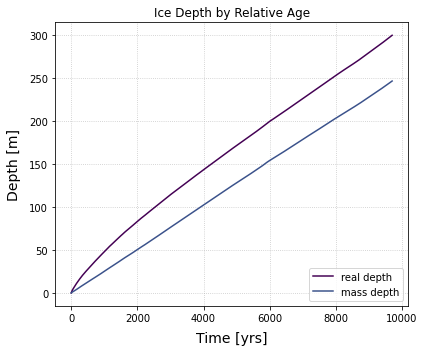

In [11]:
z_min = 0 # starting depth for plots (m)
z_start = 96.5 # starting depth of 14C accumulation (m) - close-off depth beneath firn layer
z_deep = 300 # end depth (m)

i_min = np.argmin(abs(depths_real-z_min)) # nearest depths_real index to z_min
i_start = np.argmin(abs(depths_real-z_start)) # nearest depths_real index to z_start
i_end = np.argmin(abs(depths_real-z_deep)) # nearest depths_real index to z_end

z = depths_real[i_min:i_end+1] # depth array in steps of 1-year ice age (m)
dz = depths_real[i_min+1:i_end+2] - z # bin-width of z (m)

i_int = np.arange(i_start-i_min, i_end-i_min+1) # indices of z beneath starting point for 14C accumulation

h = z_to_h(z) # mass depth corresponding to z array (m.w.e = hg/cm^2)
dh = z_to_h(depths_real[i_min+1:i_end+2]) - h # bin-width of h (m.w.e = hg/cm^2)

t = np.arange(len(z)) # ice age corresponding to z array (years)
dt = 1 # bin-width of t (years)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, z, label='real depth')
ax.plot(t, h, label='mass depth')
ax.set(xlabel='Time [yrs]',
       ylabel='Depth [m]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Depth by Relative Age')

Text(0.5, 1.0, 'Ice Density Profile')

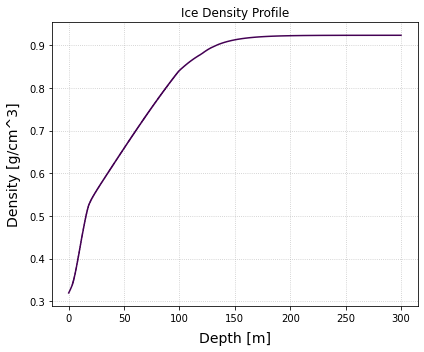

In [12]:
rho = dh/dz # calculate density from change in mass depth / real depth

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(z, rho)
ax.set(xlabel='Depth [m]',
       ylabel='Density [g/cm^3]')
#ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Density Profile')

## Muon Response Matrices

In [13]:
# Setup range of zenith angles for integration to total flux
dcosTH = 0.1
cosTH = np.arange(1,0,-dcosTH) # cosines of zenith angles in evenly space bins

In [14]:
# pick an interaction_model for MCEq

interaction_model = "SIBYLL-2.3c"
#interaction_model = "SIBYLL-2.3"
#interaction_model = "SIBYLL-2.1"
#interaction_model = "EPOS-LHC"
#interaction_model = "QGSJET-II-04"
#interaction_model = "DPMJET-III"
#interaction_model = 'DPMJETIII191'

In [15]:
density_model, density_name = ('CORSIKA', ('USStd', None)), 'CORSIKA_USStd'
#density_model, density_name = ('CORSIKA',('SouthPole', 'June')), 'CORSIKA_SP_Jun'
#density_model, density_name = ('CORSIKA',('SouthPole', 'December')), 'CORSIKA_SP_Dec'

In [16]:
elevation = 0 #m
#elevation = 3120 #m

In [17]:
# obtain matrix for surface muon spectrum from primary CR

f_surf = 'flux_surf_{}_{}_{}m.npy'.format(interaction_model, density_name, elevation)
if os.path.isfile(f_surf): # attempt to load past data
    phi_mu_surf = np.load(f_surf)
#else: # run new calculation & save
    #phi_mu_surf = flux_matrix_all(['p+', 'n0'], z, h, cosTH, dcosTH, rho=rho, interaction_model = interaction_model, density_model=density_model, elev = elevation, depth=False)
    #np.save(f_surf, phi_mu_surf)

In [18]:
# obtain matrix for underground muon spectrum from surface muons

f_depth = 'flux_depth_{}.npy'.format(interaction_model)
if os.path.isfile(f_depth): # attempt to load past data
    phi_mu_depth = np.load(f_depth)
else: # run new calculation & save
    phi_mu_depth = []
    for cth in cosTH:
        f_d = 'flux_depth_{}_{:.0f}.npy'.format(interaction_model, 180*np.arccos(cth)/np.pi)
        if os.path.isfile(f_d): # attempt to load past data
            phi_mu_depth.append(np.load(f_d))
        else: # run new calculation & save
            phi_mu_depth.append(flux_matrix_one_ang(['mu+', 'mu-'], z, h, cth, rho=rho, interaction_model = interaction_model, elev = elevation, surf=False))
            np.save(f_d, phi_mu_depth[-1])
    phi_mu_depth = np.array(phi_mu_depth)
    np.save(f_depth, phi_mu_depth)

In [188]:
phi_mu_d0 = flux_matrix_one_ang(['mu+', 'mu-'], z=z, h=h, cosTH=1, rho=rho, interaction_model = interaction_model, elev = elevation, surf=False)

Calculating muon flux response at 0.0 degrees
Propagating through ice...


100%|██████████████████████████████████████████████████████████████████████████████| 9705/9705 [43:38<00:00,  3.71it/s]


Retrieving Muon Flux...


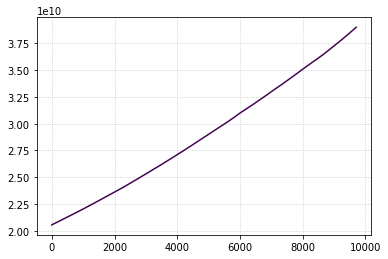

In [195]:
plt.plot(phi_mu_d0[:,-1,-1])

In [19]:
# obtain matrix for underground muon spectrum from primary CR

f_mat = 'flux_mat_{}_{}_{}m.npy'.format(interaction_model, density_name, elevation)
if os.path.isfile(f_mat): # attempt to load past data
    phi_mu_tot = np.load(f_mat)
else: # run new calculation & save
    phi_mu_tot = flux_matrix_all(['p+', 'n0'], z, h, cosTH, dcosTH, rho=rho, interaction_model = interaction_model, density_model=density_model, elev = elevation)
    np.save(f_mat, phi_mu_tot)

## Balco Calculation

In [23]:
# Is this step calculating the average momentum for a given depth and finding the atmospheric attenuation length
# for that momentum?

# If Attenuation varies by momentum, shouldn't the energy spectrum change as a result?


pressure = 65800 # surface pressure in Pa, should be 65800 for Dome C

# figure the difference in atmospheric depth from sea level in g/cm2
H = 0#(1013.25 - pressure/100)*1.019716 # the 1.019716 number is basically just 1/g accounting for needed unit conversions

# define range/momentum relation
# table for muons in standard rock in Groom and others 2001

# g/cm^2
h_range = np.array([8.516e-1, 1.542e0, 2.866e0, 5.698e0, 9.145e0, 2.676e1, 3.696e1, 5.879e1, 9.332e1, 1.524e2,
                    2.115e2, 4.418e2, 5.534e2, 7.712e2, 1.088e3, 1.599e3, 2.095e3, 3.998e3, 4.920e3, 6.724e3,
                    9.360e3, 1.362e4, 1.776e4, 3.343e4, 4.084e4, 5.495e4, 7.459e4, 1.040e5, 1.302e5, 2.129e5])

# MeV/c
momentum = np.array([4.704e1, 5.616e1, 6.802e1, 8.509e1, 1.003e2, 1.527e2, 1.764e2, 2.218e2, 2.868e2, 3.917e2,
                     4.945e2, 8.995e2, 1.101e3, 1.502e3, 2.103e3, 3.104e3, 4.104e3, 8.105e3, 1.011e4, 1.411e4,
                     2.011e4, 3.011e4, 4.011e4, 8.011e4, 1.001e5, 1.401e5, 2.001e5, 3.001e5, 4.001e5, 8.001e5])

def att_L(h):
    # effective atmospheric attenuation length for muons at mass depth h
    
    P_MeVc = np.exp(np.interp(np.log(np.clip(h,1e-5,None)*100), np.log(h_range), np.log(momentum)))
    
    return 263 + 150 * P_MeVc/1000

In [24]:
def phi_vert_slhl(h):
    """Empirical fit to vertical muon flux at sea level, presented in
    
    B Heisinger et al. “Production of selected cosmogenic radionuclides by muons: 1. Fast muons”.
    In: Earth and Planetary Science Letters 200.3 (2002), pp. 345–355. issn: 0012-821X.
    doi: https://doi.org/10.1016/S0012-821X(02)00640-4.
    
    where it was modified from the parameterization in
    
    A.I. Barbouti, B.C. Rastin, A study of the absolute intensity of muons at sea level and under
    various thicknesses of absorber, J. Phys. G 9 (1983) 1577-1595.
    
    Parameters
    -----------
    h : float or array of floats
        mass depth below surface (hg/cm^2)
        
    Returns
    --------
    Phi_v : float or array of floats
        Vertical muon flux (cm^-2 s^-1 sr^-1)
    """
    #parameters
    p = [258.5,  #p0
        -5.5e-4, #p1
        210,     #p2
        10,      #p3
        1.66,    #p4
        75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    Phi_v = p[0] * a / b / c  # cm^-2 s^-1 sr^-1
    
    return Phi_v

In [25]:
def R_vert_slhl(h):
    """Analytic derivative of above vertical muon flux function with respect to mass depth,
    derived in
    
    B Heisinger et al. “Production of selected cosmogenic radionuclides by muons: 1. Fast muons”.
    In: Earth and Planetary Science Letters 200.3 (2002), pp. 345–355. issn: 0012-821X.
    doi: https://doi.org/10.1016/S0012-821X(02)00640-4.
    
    Parameters
    -----------
    h : float or array of floats
        mass depth below surface (hg/cm^2)
        
    Returns
    --------
    R_v : float or array of floats
        Vertical muon stopping rate (hg^-1 s^-1 sr^-1)
    """
    #parameters
    p = [258.5,  #p0
        -5.5e-4, #p1
        210,     #p2
        10,      #p3
        1.66,    #p4
        75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    dadh = p[1] * a
    dbdh = 1.
    dcdh = p[4] * (h+p[3])**(p[4]-1)
    
    R_v = -p[0] * (b*c*dadh - a*c*dbdh - a*b*dcdh)/ b**2 / c**2  # hg^-1 s^-1 sr^-1
    
    return R_v

In [26]:
def phi_vert_site(h, dh, H=H, h_end=2e3):
    
    Phi_v= phi_vert_slhl(h)
    
    R_v = R_vert_slhl(h)
    
    R_site = R_v * np.exp(H/att_L(h))
    
    Phi_end = phi_vert_slhl(h_end)
    
    dh_ext = 1
    h_ext = np.arange(h[-1]+dh_ext, h_end+dh_ext, dh_ext)
    
    h_int = np.append(h, h_ext)
    dh_int = np.append(dh, dh_ext + 0*h_ext)
    
    R_int = R_vert_slhl(h_int) * np.exp(H/att_L(h_int))
    
    Phi_site = np.flip(np.cumsum(np.flip(R_int * dh_int))) + (1-np.exp(H/att_L(h_end)))*Phi_end
    
    Phi_site = Phi_site[:len(h)]
    
    return Phi_site, R_site

In [27]:
def cos_pow(h, H=H):
    #parameters
    p = [3.21,     #p0
         0.297,    #p1
         42,       #p2
         1.21e-3]  #p3
    
    #H = (1013.25 - pressure/100) * 1.019716
    #h_mod = h + H (atmospheric depth diff. from sea level)
    
    # shouldn't H be subtracted here?
    
    n = p[0] - p[1]*np.log(h + H/100 + p[2]) + p[3] * (h + H/100)
    
    dndh = -p[1]/(h + H/100 + p[2]) + p[3]
    
    return n, dndh

In [28]:
def f_mu_neg(h = None):
    K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV]
    
    return 1/(K_mu+1)

In [29]:
def phi_all(h, dh, H=H, cos_pow_func=cos_pow, f_func=f_mu_neg):
    
    n, dndh = cos_pow_func(h, H)
    
    Phi_v, R_v = phi_vert_site(h, dh, H)
    
    Phi = 2*np.pi/(n+1) * Phi_v
    
    R = f_func(h) * (2*np.pi * R_v + Phi*dndh) / (n+1)
    
    return Phi, R # cm^-2 s^-1

In [30]:
def Heisinger(h):
    #parameters
    a = 7.6
    b = 321.7
    c = 8.059e-4
    d = 50.7
    e = 5.05e-5
    
    f = 0.846
    g = 0.015
    i = 0.003139
    
    # Heisinger's fit for average Energy
    E_pred = a + b * (1-np.exp(-c*h)) + d*(1-np.exp(-e*h))

    # Heisinger's Beta correction term
    Beta_pred = f - g*np.log(h+1)+i*np.log(h+1)**2
    
    return E_pred, Beta_pred

In [31]:
Phi, R = phi_all(h, dh+h*0)
Phi_0, R_0 = phi_all(h, dh+h*0, H=0)

## Primary Spectra

In [32]:
mceq = surface_flux(1, interaction_model=interaction_model, sol=False)
E_grid = mceq._energy_grid.c

In [33]:
def get_primary(primary_model = (pm.GlobalSplineFitBeta, None), interaction_model='DPMJETIII191'):
    mceq = surface_flux(0, primary_model=primary_model, interaction_model=interaction_model, sol=False)
    pname = mceq.pman.pname2pref
    return np.concatenate((mceq._phi0[pname['p+'].lidx:pname['p+'].uidx], mceq._phi0[pname['n0'].lidx:pname['n0'].uidx]))

In [34]:
p_models = [(pm.GlobalSplineFitBeta, None), (pm.HillasGaisser2012, "H3a"), (pm.HillasGaisser2012, "H4a"), (pm.PolyGonato, False),
           (pm.GaisserStanevTilav, "3-gen"), (pm.GaisserStanevTilav, "4-gen"), (pm.CombinedGHandHG, "H3a"),
           (pm.ZatsepinSokolskaya, "pamela"), (pm.ZatsepinSokolskaya, "default"), (pm.GaisserHonda, None),
           (pm.Thunman, None), (pm.SimplePowerlaw27, None)]
model_names = ['GlobalSplineFitBeta', 'HillasGaisser2012 H3a', 'HillasGaisser2012 H4a', 'PolyGonato',
              'GaisserStanevTilav 3-gen', 'GaisserStanevTilav 4-gen', 'CombinedGHandHG H3a',
              'ZatsepinSokolskaya pamela', 'ZatsepinSokolskaya default', 'GaisserHonda',
              'Thunman', 'SimplePowerlaw27']

In [38]:
Primaries = [get_primary(p, interaction_model) for p in p_models]

In [39]:
MU_spect = [phi_mu_tot @ phi0 for phi0 in Primaries]
MU_tot = [np.sum(mu_spect, axis=1) for mu_spect in MU_spect]
E_MU_avg = [np.sum(MU_spect[i]*E_grid, axis=1)/MU_tot[i] for i in range(len(MU_spect))]

## Surface Muon Spectrum

In [40]:
A_G = 0.14 #scale factor
gamma = 2.7 #index of energy spectrum
epsilon_pi = 115/1.1 #critical energy of pion (GeV)
epsilon_K = 850/1.1 #critical energy of kaon (GeV)
B_G = 0.054 # ratio factor between pion and kaon produced muons

def gaisser(E0, cosTH):
    # surface flux calculation
    Phi_G = A_G * E0**(-gamma) * (1/(1+E0*cosTH/epsilon_pi) + B_G/(1+E0*cosTH/epsilon_K))
    
    return Phi_G
    
def gaisser_tang(E0, cosTH):
    #cosTH_mod parameters
    p1 = 0.102573
    p2 = -0.068287
    p3 = 0.958633
    p4 = 0.0407253
    p5 = 0.817285
    
    #modified cosine to account for atmospheric curvature
    cosTH_mod = np.sqrt((cosTH**2 + p1**2 + p2*cosTH**p3 + p4*cosTH**p5)/(1+p1**2+p2+p4))
    
    #piecewise scale factor
    A_T = 1 * (E0 > 100/cosTH_mod) + 1.1 * (90 * np.sqrt(cosTH+0.001)/1030)**(4.5/(E0*cosTH_mod)) * (E0 <= 100/cosTH_mod)
    
    #proportion of prompt muons produced by the decay of charmed particles
    r_c = 10**(-4) * (E0 <= 100/cosTH_mod)
    
    E0_hat = E0 + 2.06e-3 * (950/cosTH_mod - 90)
    
    Phi_T = A_T * A_G * E0**(-gamma) * (1/(1+E0_hat*cosTH_mod/epsilon_pi) + B_G/(1+E0_hat*cosTH_mod/epsilon_K) + r_c)
    
    return Phi_T

In [41]:
def bugaev_reyna(E0, cosTH):
    A_B = 0.00253
    a0 = 0.2455
    a1 = 1.288
    a2 = -0.2555
    a3 = 0.0209
    
    y = np.log10(E0*cosTH)
    
    Phi_R = cosTH**3 * A_B * (E0*cosTH)**(-(a3*y**3 + a2*y**2 + a1*y + a0))
    
    return Phi_R

In [42]:
def judge_nash(E0, cosTH):
    H_pi = 114 #GeV
    H_K = 851 #GeV
    gamma_pi = 2.7
    gamma_K = gamma_pi
    A_pi = 0.28
    A_K = 0.0455
    y0 = 1000 # Atmosphere depth at sea level? (g/cm^2)
    r_pi = 0.76 #muon to parent pion energy ratio
    r_K = 0.523 #muon to parent kaon energy ratio
    q = 2.2e-3 #mean energy loss of the muon in the atmosphere (GeV cm^2/g)
    tau_mu = 2.2e-6 #mean muon lifetime (s)
    tau_pi = 2.61e-8 #mean pion lifetime (s)
    tau_K = 1.24e-8 #mean kaon lifetime (s)
    g = 981.3 #acceleration due to gravity (cm/s^2)
    R = 8.314e7 #gas constant (g cm^2/s^2 /K /mol)
    m_mu = 105.659e-3 #muon rest mass (GeV/c^2)
    m_pi = 139.580e-3 #pion rest mass (GeV/c^2)
    m_K = 493.800e-3 #kaon rest mass (GeV/c^2)
    c = 3e10 #speed of light (cm/s)
    M = 28.966 #effective molecular weight of air (g/mol)
    
    #effective mean temperature of the atmosphere as experienced at zenith angle theta
    T_e = 220 #220 #from Chatzidakis 2015
    
    H_mu = R*m_mu*T_e / c / M / g / tau_mu
    
    E_pi = (E0 + q*y0*(1/cosTH - 0.0874))/r_pi
    
    #H_pi = R*m_pi*c*T_e / M/g/tau_pi
    
    W_pi = (0.0874 * cosTH * (1- q * (y0/cosTH - 90)/r_pi/E_pi))**(H_mu/cosTH/(r_pi*E_pi+90*q))
    
    E_K = (E0 + q*y0*(1/cosTH - 0.0874))/r_K
    
    #H_K = R*m_K*c*T_e / M / g /tau_K
    
    W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))
    
    Phi_J = A_pi*W_pi*E_pi**(-gamma_pi)*H_pi / (E_pi*cosTH + H_pi) + A_K*W_K*E_K**(-gamma_K)*H_K / (E_K*cosTH + H_K)
    
    return Phi_J

In [43]:
def SDC(E0, cosTH):
    # Smith & Duller / Chatzidakis
    
    A = 0.002382 # fitting parameter
    r = 0.76 # Ratio of muon energy to pion energy
    a = 2.500e-3 # Muon rate of energy loss in air (GeV / (g/cm^2))
    y0 = 1000 # Atmosphere depth at sea level (g/cm^2)
    gamma = 8/3 # fitting parameter
    b_mu = 0.800 # Correction factor related to atmospheric temperature
    m_mu = 105.659e-3 # Rest mass of muon (GeV/c^2)
    tau_mu0 = 2.2e-6 # Mean lifetime of muon at rest (s)
    rho0 = 0.00123 # Density of atmosphere at sea level (g/cm^3)
    c = 3e10 # speed of light (cm/s)
    lambda_pi = 120 # Absorption mean free path of pions (g/cm^2)
    b = 0.771 # coefficient to modify the isothermal atmosphere approximation
    tau0 = 2.61e-8 # Mean lifetime of pion at rest (s)
    m_pi = 139.580e-3 # Rest mass of pion (GeV/c^2)
    j_pi = 148.16 # m_pi * y0 * c / (tau0 * rho0) GeV
    
    # energy of pion that produced muon
    E_pi = (E0 + a*y0*(1/cosTH - 0.100))/r
    
    B_mu = b_mu * m_mu * y0 / (c * tau_mu0 * rho0)
    
    # Probability for muons to reach sea level
    P_mu = (0.100 * cosTH * (1-a*(y0/cosTH - 100)/(r * E_pi)))**(B_mu / ((r*E_pi + 100*a)*cosTH))
    
    Phi_S = A * E_pi**(-gamma) * P_mu * lambda_pi * b * j_pi/(E_pi* cosTH + b * j_pi)
    
    return Phi_S

In [44]:
def judge_nash(E0, cosTH):
    H_pi = 114 #GeV
    H_K = 851 #GeV
    gamma_pi = 2.7
    gamma_K = gamma_pi
    A_pi = 0.28
    A_K = 0.0455
    y0 = 1000 # Atmosphere depth at sea level? (g/cm^2)
    r_pi = 0.76 #muon to parent pion energy ratio
    r_K = 0.523 #muon to parent kaon energy ratio
    q = 2.2e-3 #mean energy loss of the muon in the atmosphere (GeV cm^2/g)
    tau_mu = 2.2e-6 #mean muon lifetime (s)
    tau_pi = 2.61e-8 #mean pion lifetime (s)
    tau_K = 1.24e-8 #mean kaon lifetime (s)
    g = 981.3 #acceleration due to gravity (cm/s^2)
    R = 8.314e7 #gas constant (g cm^2/s^2 /K /mol)
    m_mu = 105.659e-3 #muon rest mass (GeV/c^2)
    m_pi = 139.580e-3 #pion rest mass (GeV/c^2)
    m_K = 493.800e-3 #kaon rest mass (GeV/c^2)
    c = 3e10 #speed of light (cm/s)
    M = 28.966 #effective molecular weight of air (g/mol)
    
    #effective mean temperature of the atmosphere as experienced at zenith angle theta
    T_e = 220 #220 #from Chatzidakis 2015
    
    H_mu = R*m_mu*T_e / c / M / g / tau_mu
    
    E_pi = (E0 + q*y0*(1/cosTH - 0.0874))/r_pi
    
    #H_pi = R*m_pi*c*T_e / M/g/tau_pi
    
    W_pi = (0.0874 * cosTH * (1- q * (y0/cosTH - 90)/r_pi/E_pi))**(H_mu/cosTH/(r_pi*E_pi+90*q))
    
    E_K = (E0 + q*y0*(1/cosTH - 0.0874))/r_K
    
    #H_K = R*m_K*c*T_e / M / g /tau_K
    
    W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))
    
    Phi_J = A_pi*W_pi*E_pi**(-gamma_pi)*H_pi / (E_pi*cosTH + H_pi) + A_K*W_K*E_K**(-gamma_K)*H_K / (E_K*cosTH + H_K)
    
    return np.nan_to_num(Phi_J)

In [196]:
E_flux = np.expand_dims(mceq._energy_grid.c,axis=1)
SDC_flux = SDC(E_flux, cosTH).T

# Negative muon ratio (Cited by Heisinger)
K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV]

phi_SDC = np.array([0*mceq._solution for cth in cosTH])
phi_SDC[:, mceq.pman.pname2pref['mu+'].lidx : mceq.pman.pname2pref['mu+'].uidx] = SDC_flux / (K_mu+1) # positive muons
phi_SDC[:, mceq.pman.pname2pref['mu-'].lidx : mceq.pman.pname2pref['mu-'].uidx] = SDC_flux / (1 + 1/K_mu) # negative muons
#phi_SDC = np.concatenate((SDC_flux / (K_mu+1), SDC_flux / (1 + 1/K_mu)), axis=1)

In [197]:
mceq_depth_SDC = [depth_flux(phi_SDC[i], z, h, cosTH[i], rho, interaction_model=interaction_model, use_tqdm=True) for i in range(len(cosTH))]

100%|███████████████████████████████████████████████████████████████████████████| 29139/29139 [01:54<00:00, 255.03it/s]


In [198]:
JN_flux = judge_nash(E_flux, cosTH).T

phi_JN = np.array([0*mceq._solution for cth in cosTH])
phi_JN[:, mceq.pman.pname2pref['mu+'].lidx : mceq.pman.pname2pref['mu+'].uidx] = JN_flux / (K_mu+1) # positive muons
phi_JN[:, mceq.pman.pname2pref['mu-'].lidx : mceq.pman.pname2pref['mu-'].uidx] = JN_flux / (1 + 1/K_mu) # negative muons
#phi_JN = np.concatenate((JN_flux / (K_mu+1), JN_flux / (1 + 1/K_mu)), axis=1)

C:\Users\walte\AppData\Local\Temp/ipykernel_14076/4125256535.py:38: RuntimeWarning: invalid value encountered in power
  W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))


In [199]:
mceq_depth_JN = [depth_flux(phi_JN[i], z, h, cosTH[i], rho, interaction_model=interaction_model, use_tqdm=True) for i in range(len(cosTH))]

100%|███████████████████████████████████████████████████████████████████████████| 29139/29139 [01:57<00:00, 249.03it/s]


In [200]:
import daemonflux
df_cut = (E_grid <= 1e9)
daemon_flux_pos = daemonflux.Flux(location='generic').flux(E_grid[df_cut], np.arccos(cosTH)*180/np.pi, 'mu+')/E_flux[df_cut]**3
daemon_flux_neg = daemonflux.Flux(location='generic').flux(E_grid[df_cut], np.arccos(cosTH)*180/np.pi, 'mu+')/E_flux[df_cut]**3

phi_df = np.array([0*mceq._solution for cth in cosTH])
phi_df[:, mceq.pman.pname2pref['mu+'].lidx : mceq.pman.pname2pref['mu+'].lidx+np.sum(df_cut)] = daemon_flux_pos.T # positive muons
phi_df[:, mceq.pman.pname2pref['mu-'].lidx : mceq.pman.pname2pref['mu-'].lidx+np.sum(df_cut)] = daemon_flux_neg.T # negative muons

#phi_df = np.zeros((len(cosTH),len(E_grid)*2))
#phi_df[:,:np.sum(df_cut)] = daemon_flux_pos.T
#phi_df[:,len(E_grid):len(E_grid)+np.sum(df_cut)] = daemon_flux_neg.T

In [201]:
mceq_depth_df = [depth_flux(phi_df[i], z, h, cosTH[i], rho, interaction_model=interaction_model, use_tqdm=True) for i in range(len(cosTH))]

100%|███████████████████████████████████████████████████████████████████████████| 29139/29139 [01:54<00:00, 254.08it/s]


In [202]:
longitudinal_spectrum_SDC = 2*np.pi*dcosTH*np.sum([[mceq_depth_SDC[i].get_solution('mu-', grid_idx=idx, integrate=True)+mceq_depth_SDC[i].get_solution('mu+', grid_idx=idx, integrate=True) for idx in range(len(h))] for i in range(len(cosTH))], axis=0)
#longitudinal_spectrum_SDC = 2*np.pi*dcosTH*np.sum([(phi_mu_depth[i]@phi_SDC[i]) for i in range(len(cosTH))], axis=0)

Spec_tot_SDC = np.sum(longitudinal_spectrum_SDC, axis=1) # number of particles per cm^2 per s?
E_avg_SDC = np.sum(longitudinal_spectrum_SDC * E_grid, axis=1)/Spec_tot_SDC
E_alph_SDC = np.sum(longitudinal_spectrum_SDC * E_grid**0.75, axis=1)

R_SDC = -np.diff(Spec_tot_SDC, append=0)/dh
R_SDC[-1] = 0

In [204]:
longitudinal_spectrum_JN = 2*np.pi*dcosTH*np.sum([[mceq_depth_JN[i].get_solution('mu-', grid_idx=idx, integrate=True)+mceq_depth_JN[i].get_solution('mu+', grid_idx=idx, integrate=True) for idx in range(len(h))] for i in range(len(cosTH))], axis=0)
#longitudinal_spectrum_JN = 2*np.pi*dcosTH*np.sum([(phi_mu_depth[i]@phi_JN[i]) for i in range(len(cosTH))], axis=0)

Spec_tot_JN = np.sum(longitudinal_spectrum_JN, axis=1) # number of particles per cm^2 per s?
E_avg_JN = np.sum(longitudinal_spectrum_JN * E_grid, axis=1)/Spec_tot_JN
E_alph_JN = np.sum(longitudinal_spectrum_JN * E_grid**0.75, axis=1)

R_JN = -np.diff(Spec_tot_JN, append=0)/dh
R_JN[-1] = 0

In [205]:
longitudinal_spectrum_df = 2*np.pi*dcosTH*np.sum([[mceq_depth_df[i].get_solution('mu-', grid_idx=idx, integrate=True)+mceq_depth_df[i].get_solution('mu+', grid_idx=idx, integrate=True) for idx in range(len(h))] for i in range(len(cosTH))], axis=0)
#longitudinal_spectrum_df = 2*np.pi*dcosTH*np.sum([(phi_mu_depth[i]@phi_df[i]) for i in range(len(cosTH))], axis=0)

Spec_tot_df = np.sum(longitudinal_spectrum_df, axis=1) # number of particles per cm^2 per s?
E_avg_df = np.sum(longitudinal_spectrum_df * E_grid, axis=1)/Spec_tot_df
E_alph_df = np.sum(longitudinal_spectrum_df * E_grid**0.75, axis=1)

R_df = -np.diff(Spec_tot_df, append=0)/dh
R_df[-1] = 0

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from matplotlib.colors import LogNorm, Normalize
from numpy import trapz

In [78]:
input_file = 'Walter/muon_fluxes_per_zenith_3120_AIRS_SP_december.pkl'
with open(input_file, 'rb') as f:
    data = pickle.load(f)
print(data['GSF']['SIBYLL2.3c'].keys())

e_grid_bins = np.logspace(-1.1, 11, 122)  # Bin edges
e_grid_width = np.diff(e_grid_bins)  # Bin widths
ENERGIES = np.sqrt(e_grid_bins[1:] * e_grid_bins[:-1])  # Bin centers


dict_keys(['E_grid', 'muon_flux'])


In [79]:
survival_file='Walter/survival_prop_tensor_v_1m_ice.pkl'
with open(survival_file, 'rb') as f:
    svp_data = pickle.load(f)
print(svp_data.keys())
survival_probability_tensor = svp_data['survival_probability_tensor']

dict_keys(['surface_energies', 'slant_depths', 'underground_energies', 'survival_probability_tensor'])


In [80]:
icedepth = np.array([1, 10, 50, 100, 150, 200, 250, 300])

intensities = []
for depth in icedepth:
    survival_file=f'Walter/survival_prop_tensor_v_{depth}m_ice.pkl'
    with open(survival_file, 'rb') as f:
        svp_data = pickle.load(f)
    survival_probability_tensor = svp_data['survival_probability_tensor']
    underground_flux_zen = np.zeros((121, 10))
    for i_zen, zen in enumerate(data['GSF']['SIBYLL2.3c']['E_grid'].keys()):
        energy = data['GSF']['SIBYLL2.3c']['E_grid'][zen]
        surf_flux = data['GSF']['SIBYLL2.3c']['muon_flux'][zen]
        surv_prob = survival_probability_tensor[:, i_zen, :]
        uflux = np.dot(surf_flux * e_grid_width, surv_prob) / e_grid_width
        underground_flux_zen[:, i_zen] = uflux
    underground_flux = np.sum(underground_flux_zen, axis=1) * 0.1 * 2* np.pi
    tot_flux = trapz(underground_flux, energy)
    intensities.append(tot_flux)
    print('Total underground flux:', tot_flux)




Total underground flux: 0.02428477642513352
Total underground flux: 0.01112671718889753
Total underground flux: 0.0014262144965292215
Total underground flux: 0.0004034406514812439
Total underground flux: 0.00018222638678716443
Total underground flux: 9.995256728216096e-05
Total underground flux: 6.122171013752886e-05
Total underground flux: 4.01195875680581e-05


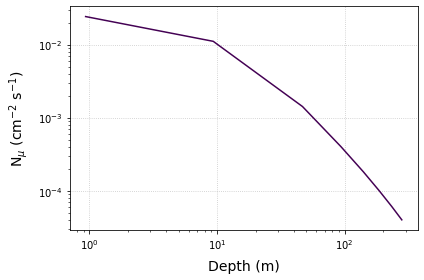

In [81]:
fig, ax = plt.subplots()
vertical_depth = icedepth * (0.93/0.997) 
ax.plot(vertical_depth, intensities)
ax.set_xlabel('Depth (m)', fontsize=14)
ax.set_ylabel(r'N$_\mu$ (cm$^{-2}$ s$^{-1}$)', fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
fig.tight_layout()
fig.savefig('underground_muon_flux_depth.pdf', dpi=300)

## Underground Muon Flux Plots

In [258]:
h_data = dict()
Phi_v_data = dict()
dPhi_v_data = dict()
n_data = dict()
Phi_data = dict()
dPhi_data = dict()
data_name = dict()
c = dict()

#Rogers '84 data
i = 'R84'
h_data[i] = np.array([10.3, 18.0, 20.9, 38.4, 45.6, 59.0, 71.7, 100, 111, 143, 175]) #hg/cm^2
Phi_v_data[i] = np.array([3.70e-3, 2.24e-3, 1.83e-3, 9.61e-4, 7.59e-4, 4.99e-4, 3.90e-4, 2.02e-4, 1.80e-4, 1.10e-4, 7.39e-5]) #sr^-1 cm^-2 s^-1
dPhi_v_data[i] = np.array([0.32e-3, 0.15e-3, 0.18e-3, 0.85e-4, 0.72e-4, 0.41e-4, 0.33e-4, 0.18e-4, 0.16e-4, 0.10e-4, 0.88e-5])
n_data[i] = cos_pow(h_data[i], 0)[0]
Phi_data[i] = 2*np.pi/(n_data[i]+1) * Phi_v_data[i]
dPhi_data[i] = 2*np.pi/(n_data[i]+1) * dPhi_v_data[i]
data_name[i] = 'Rogers 84'
c[i] = 'r'

#Barbouti '83 data
i = 'B83'
h_data[i] = np.array([11.62, 12.12, 14.32, 19.28, 24.24, 29.06, 47.72, 52.42])-10.33 #hg/cm^2
Phi_v_data[i] = np.array([9.13, 8.87, 7.66, 5.56,4.15,3.20,1.40,1.19])*1e-3 # cm^-2 s^-1 sr^-1
dPhi_v_data[i] = np.array([0.12, 0.12, 0.09, 0.06, 0.05, 0.04, 0.02, 0.06])*1e-3
n_data[i] = cos_pow(h_data[i], 0)[0]
Phi_data[i] = 2*np.pi/(n_data[i]+1) * Phi_v_data[i]
dPhi_data[i] = 2*np.pi/(n_data[i]+1) * dPhi_v_data[i]
data_name[i] = 'Barbouti 83'
c[i] = 'b'

# Bergamasco '70 data
i = 'B71'
h_data[i] = np.array([
    #50,
    106,
    158,
    238,
    #4270
])-10.33 # m.w.e.
Phi_v_data[i] = np.array([
    #2.36e-4,
    2.36e-4,
    1.20e-4,
    5.00e-5,
    # 4.79e-9
]) # cm^-2 s^-1 sr^-1
dPhi_v_data[i] = np.array([
    #0.02e-4,
    0.02e-4,
    0.01e-4,
    0.05e-5,
    # 0.23e-9
]) # cm^-2 s^-1 sr^-1
n_data[i] = cos_pow(h_data[i], 0)[0]
Phi_data[i] = 2*np.pi/(n_data[i]+1) * Phi_v_data[i]
dPhi_data[i] = 2*np.pi/(n_data[i]+1) * dPhi_v_data[i]
data_name[i] = 'Bergamasco 71'
c[i] = 'g'

# Crookes '73 data (taken from various sources)
i = 'C73'
h_data[i] = np.array([
    860, # Randall and Hazen
    1510, # Bollinger
    1850,
    1584, # Barret et al.
    110, # Sreekantan and Naranan
    391,
    485,
    694,
    895,
    310, # Avan and Avan
    590,
    1290,
    833, # Miyake et al.
    1888,
    149, #Castagnoli et al.
    299,
    1319,
    826, # Achar et al.
    1881,
    764, #Krishnaswamy
    1510,
    71.6, #Stockel
    734,
    1068,
    890 # Sheldon et al.
])-10.33 # hg/cm^2
Phi_v_data[i] = np.array([
    2.17e-6, # Randall and Hazen
    3.90e-7, # Bollinger
    1.91e-7,
    3.25e-7, # Barret et al.
    2.87e-4, # Sreekantan and Naranan
    1.76e-5,
    1.24e-5,
    5.55e-5, #(sic) should probably be e-6
    2.37e-6,
    3.80e-5, # Avan and Avan
    7.3e-6,
    8.0e-7,
    2.51e-6, # Miyake et al.
    1.77e-7,
    1.70e-4, #Castagnoli et al.
    4.60e-5,
    5.60e-7,
    2.39e-6, # Achar et al.
    2.00e-7,
    2.7e-6, #Krishnaswamy
    3.4e-7,
    5.00e-4, #Stockel
    3.12e-6,
    1.03e-6,
    1.65e-6 # Sheldon et al.
]) # cm^-2 s^-1 sr^-1
dPhi_v_data[i] = np.array([
    0.02e-6, # Randall and Hazen
    0.08e-7, # Bollinger
    0.04e-7,
    0.05e-7, # Barret et al.
    0.23e-4, # Sreekantan and Naranan
    0.24e-5,
    0.13e-5,
    0.70e-5,#(sic) should probably be e-6
    0.27e-6,
    0.17e-5, # Avan and Avan
    0.4e-6,
    0.6e-7,
    0.15e-6, # Miyake et al.
    0.07e-7,
    0.04e-4, #Castagnoli et al.
    0.01e-5,
    0.07e-7,
    0.15e-6, # Achar et al.
    0.12e-7,
    0.1e-6, #Krishnaswamy
    0.1e-7,
    0.17e-4, #Stockel
    0.15e-6,
    0.04e-6,
    0.09e-6 # Sheldon et al.
]) # cm^-2 s^-1 sr^-1
n_data[i] = cos_pow(h_data[i], 0)[0]
Phi_data[i] = 2*np.pi/(n_data[i]+1) * Phi_v_data[i]
dPhi_data[i] = 2*np.pi/(n_data[i]+1) * dPhi_v_data[i]
data_name[i] = 'Crookes 73'
c[i] = 'cyan'

In [259]:
mu_tot_top = np.max(MU_tot, axis=0)
mu_tot_bot = np.min(MU_tot, axis=0)

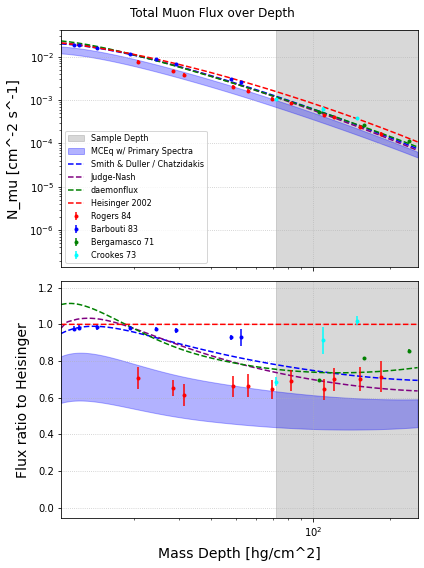

In [268]:
h0 = 10.33

use_Heisinger = False

if use_Heisinger:
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(6,12), tight_layout=True, sharex=True)
else:
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6,8), tight_layout=True, sharex=True)

ax1.axvspan(h[i_int][0]+h0, h[-1]+h0, color='grey', alpha=0.3, label='Sample Depth')
ax2.axvspan(h[i_int][0]+h0, h[-1]+h0, color='grey', alpha=0.3, label='Sample Depth')
if use_Heisinger:
    ax3.axvspan(h[i_int][0]+h0, h[-1]+h0, color='grey', alpha=0.3, label='Sample Depth')
#for i,mu_tot in enumerate(MU_tot):
    #if i//5 == 0:
        #ls = '-'
    #elif i//5 == 1:
        #ls = '-.'
    #else:
        #ls = ':'
    #ax1.plot(h+h0, mu_tot, ls=ls, label=model_names[i])
    #ax2.plot(h+h0, mu_tot/Phi, ls=ls, label=model_names[i])
    #ax3.plot(h+h0, mu_tot/Phi_0, ls=ls, label=model_names[i])
ax1.fill_between(h+h0, mu_tot_bot, mu_tot_top, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax2.fill_between(h+h0, mu_tot_bot/Phi, mu_tot_top/Phi, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
if use_Heisinger:
    ax3.fill_between(h+h0, mu_tot_bot/Phi_0, mu_tot_top/Phi_0, label='MCEq w/ Primary Spectra')
    
ax1.plot(h+h0, Spec_tot_SDC, ls='--', c='blue', label='Smith & Duller / Chatzidakis')
ax1.plot(h+h0, Spec_tot_JN, ls='--', c='purple', label='Judge-Nash')
ax1.plot(h+h0, Spec_tot_df, ls='--', c='g', label='daemonflux')
ax1.plot(h+h0, Phi_0, ls='--', c='red', label='Heisinger 2002')
#ax1.plot(h+h0, Phi, ls='--', c='orange', label='Balco elev. corrected')
#ax1.scatter(vertical_depth+h0, intensities, c='magenta', label='Lilly Pyras Proposal', zorder=3)

ax2.plot(h+h0, Spec_tot_SDC/Phi, ls='--', c='blue', label='Smith & Duller / Chatzidakis')
ax2.plot(h+h0, Spec_tot_JN/Phi, ls='--', c='purple', label='Judge-Nash')
ax2.plot(h+h0, Spec_tot_df/Phi, ls='--', c='g', label='daemonflux')
ax2.plot(h+h0, Phi_0/Phi, ls='--', c='red', label='Heisinger 2002')
#ax2.plot(h+h0, Phi/Phi, ls='--', c='orange', label='Balco elev. corrected')
#ax2.scatter(vertical_depth+h0, intensities/Phi[np.argmin(abs(h.reshape((-1,1))-vertical_depth.reshape((1,-1))), axis=0)], c='magenta', zorder=3)

if use_Heisinger:
    ax3.plot(h+h0, Spec_tot_SDC/Phi_0, ls='--', c='blue', label='Smith & Duller / Chatzidakis')
    ax3.plot(h+h0, Spec_tot_JN/Phi_0, ls='--', c='purple', label='Judge-Nash')
    ax3.plot(h+h0, Spec_tot_df/Phi_0, ls='--', c='g', label='daemonflux')
    ax3.plot(h+h0, Phi_0/Phi_0, ls='--', c='red', label='Heisinger 2002')
    #ax3.plot(h+h0, Phi/Phi_0, ls='--', c='orange', label='Balco elev. corrected')
    #ax3.scatter(vertical_depth+h0, intensities/Phi_0[np.argmin(abs(h.reshape((-1,1))-vertical_depth.reshape((1,-1))), axis=0)], c='magenta', zorder=3)

for i in h_data.keys():
    ax1.errorbar(h_data[i]+h0, Phi_data[i], yerr=dPhi_data[i], c=c[i], fmt='.', label=data_name[i], zorder=3)
    ax2.errorbar(h_data[i]+h0, Phi_data[i]/Phi[np.argmin(abs(h.reshape((-1,1))-h_data[i].reshape((1,-1))), axis=0)], yerr=dPhi_data[i]/Phi[np.argmin(abs(h.reshape((-1,1))-h_data[i].reshape((1,-1))), axis=0)], c=c[i], fmt='.', label=data_name[i], zorder=3)
    if use_Heisinger:
        ax3.errorbar(h_data[i]+h0, Phi_data[i]/Phi_0[np.argmin(abs(h.reshape((-1,1))-h_data[i].reshape((1,-1))), axis=0)], yerr=dPhi_data[i]/Phi_0[np.argmin(abs(h.reshape((-1,1))-h_data[i].reshape((1,-1))), axis=0)], c=c[i], fmt='.', label=data_name[i], zorder=3)

ax1.set(xlim = (max(h0,1), h[-1]+h0),
       xscale = 'log',
       #xlabel='Mass Depth [hg/cm^2]',
       yscale = 'log',
       ylabel='N_mu [cm^-2 s^-1]')
ax1.legend(loc='lower left', fontsize=8)
ax2.set(xlim = (max(h0,1), h[-1]+h0),
       xscale = 'log',
       #xlabel='Mass Depth [hg/cm^2]',
       #yscale = 'log',
       ylabel='Flux ratio to Heisinger')

if use_Heisinger:
    ax3.set(xlim = (max(h0,1), h[-1]+h0),
           xscale = 'log',
           xlabel='Mass Depth [hg/cm^2]',
           #yscale = 'log',
           ylabel='Flux ratio to Heisinger')
else:
    ax2.set(xlabel='Mass Depth [hg/cm^2]')

plt.suptitle('Total Muon Flux over Depth')
plt.show()

In [85]:
E_mu_avg_top = np.max(E_MU_avg, axis=0)
E_mu_avg_bot = np.min(E_MU_avg, axis=0)

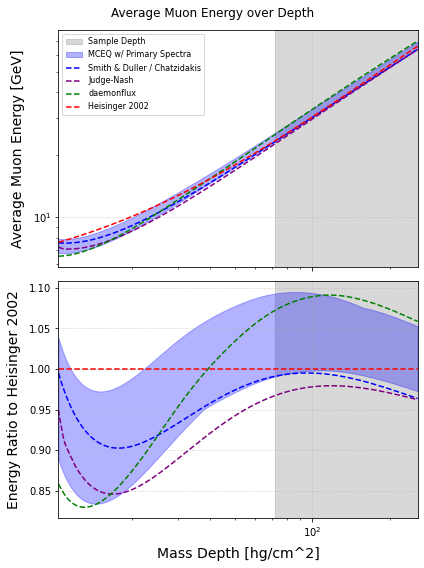

In [265]:
h0 = 10.33 # surface mass depth

E_pred, Beta_pred = Heisinger(h)

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6,8), tight_layout=True, sharex=True)
ax1.axvspan(h[i_int][0]+h0, h[-1]+h0, color='grey', alpha=0.3, label='Sample Depth')
ax2.axvspan(h[i_int][0]+h0, h[-1]+h0, color='grey', alpha=0.3, label='Sample Depth')
#for i,E_mu_avg in enumerate(E_MU_avg):
    #if i//5 == 0:
        #ls = '-'
    #elif i//5 == 1:
        #ls = '-.'
    #else:
        #ls = ':'
    #ax1.plot(h+10.33, E_mu_avg, ls=ls, label=model_names[i])
    #ax2.plot(h+10.33, E_mu_avg/E_pred, ls=ls, label=model_names[i])
ax1.fill_between(h+h0, E_mu_avg_bot, E_mu_avg_top, color='blue', alpha=0.3, label='MCEQ w/ Primary Spectra')
ax2.fill_between(h+h0, E_mu_avg_bot/E_pred, E_mu_avg_top/E_pred, color='blue', alpha=0.3, label='MCEQ w/ Primary Spectra')

ax1.plot(h+h0, E_avg_SDC, ls='--', c='blue', label='Smith & Duller / Chatzidakis')
ax1.plot(h+h0, E_avg_JN, ls='--', c='purple', label='Judge-Nash')
ax1.plot(h+h0, E_avg_df, ls='--', c='g', label='daemonflux')
ax1.plot(h+h0, E_pred, ls='--', c='red', label='Heisinger 2002')

ax2.plot(h+h0, E_avg_SDC/E_pred, ls='--', c='blue', label='Smith & Duller / Chatzidakis')
ax2.plot(h+h0, E_avg_JN/E_pred, ls='--', c='purple', label='Judge-Nash')
ax2.plot(h+h0, E_avg_df/E_pred, ls='--', c='g', label='daemonflux')
ax2.plot(h+h0, E_pred/E_pred, ls='--', c='red', label='Heisinger 2002')

ax1.set(xlim = (max(h0,1), h[-1]+h0),
       xscale = 'log',
       #xlabel='Mass Depth [hg/cm^2]',
       #ylim = (1,1000),
       yscale = 'log',
       ylabel='Average Muon Energy [GeV]')
ax1.legend(loc='upper left', fontsize=8)

ax2.set(xlim = (max(h0,1), h[-1]+h0),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       #ylim = (1,1000),
       #yscale = 'log',
       ylabel='Energy Ratio to Heisinger 2002')

plt.suptitle('Average Muon Energy over Depth')
plt.show()

## 14C Production Rates

In [208]:
# Negative Muon Capture parameters (Heisinger)
f_C = 1 # value should be absolute
f_D = 0.1828 #error unknown
f_star, df_star = 0.137, 0.011 
#f_star, df_star = 4.4e-3/f_C/f_D, 2.6e-3/f_C/f_D

# Fast Muon Interaction parameters (Heisinger)
sigma_190, dsigma_190 = 4.5e-28, 2.5e-28 #cm^2
alpha = 0.75
#sigma_190, dsigma_190 = 2.4e-30*190**alpha, 1.8e-30*190**alpha #Dyonisius 2023
#sigma_0 = sigma_190 / 190**alpha #8.8e-30 +/- 4.9e-30 cm^2 = 8.8 +/- 4.9 mu b
N = 6.022e23 / 0.1802 # hg^-1

# Decay parameter
lambd=1.21e-4 #yr^-1

# Production rate adjustment from Taylor Glacier data
f_neg = 0.066
f_fast = 0.072

In [209]:
def P_calc(R, E_mu_alph, alpha=alpha):
    
    sigma_0 = sigma_190 / 190**alpha #8.8e-30 +/- 4.9e-30 cm^2 = 8.8 +/- 4.9 mu b
    
    P_neg = f_mu_neg() * R * f_C * f_D * f_star
    
    P_fast = sigma_0 * E_mu_alph * N
    
    return np.expand_dims(np.array([P_neg, P_fast]), axis=-1) /100 * 60 * 60 * 24 * 365.25 # g^-1, a^-1

In [210]:
P_pred = P_calc(R/f_mu_neg(), Phi*E_pred**alpha*Beta_pred)

In [211]:
P_SDC = P_calc(R_SDC, E_alph_SDC)

In [212]:
P_JN = P_calc(R_JN, E_alph_JN)

In [213]:
P_df = P_calc(R_df, E_alph_df)

## 14C Production Rates Matrix Calculation

In [214]:
INT_neg = -np.diff(np.sum(phi_mu_tot, axis=1), axis=0, append=0)/np.reshape(dh, (-1,1)) * f_C * f_D * f_star * f_mu_neg() /100 * 60 * 60 * 24 * 365.25
INT_neg[-1] = 0

In [215]:
INT_fast = np.sum(phi_mu_tot * np.reshape(E_grid, (1,-1,1))**alpha, axis=1) * sigma_190 / 190**alpha * N /100 * 60 * 60 * 24 * 365.25

In [216]:
INT = np.expand_dims(np.array([INT_neg, INT_fast]),axis=(1,2))

In [217]:
Phi0 = np.expand_dims(np.array(Primaries), axis=(1,3))

In [218]:
P_Rates = INT @ Phi0

In [219]:
np.shape(P_Rates)

(2, 12, 1, 9705, 1)

## Production Rate Plots

In [220]:
P_Rates_top = np.max(P_Rates, axis=(1,2,-1))
P_Rates_bot = np.min(P_Rates, axis=(1,2,-1))

Text(0.5, 0.98, 'In Situ 14CO Production Rates over Depth')

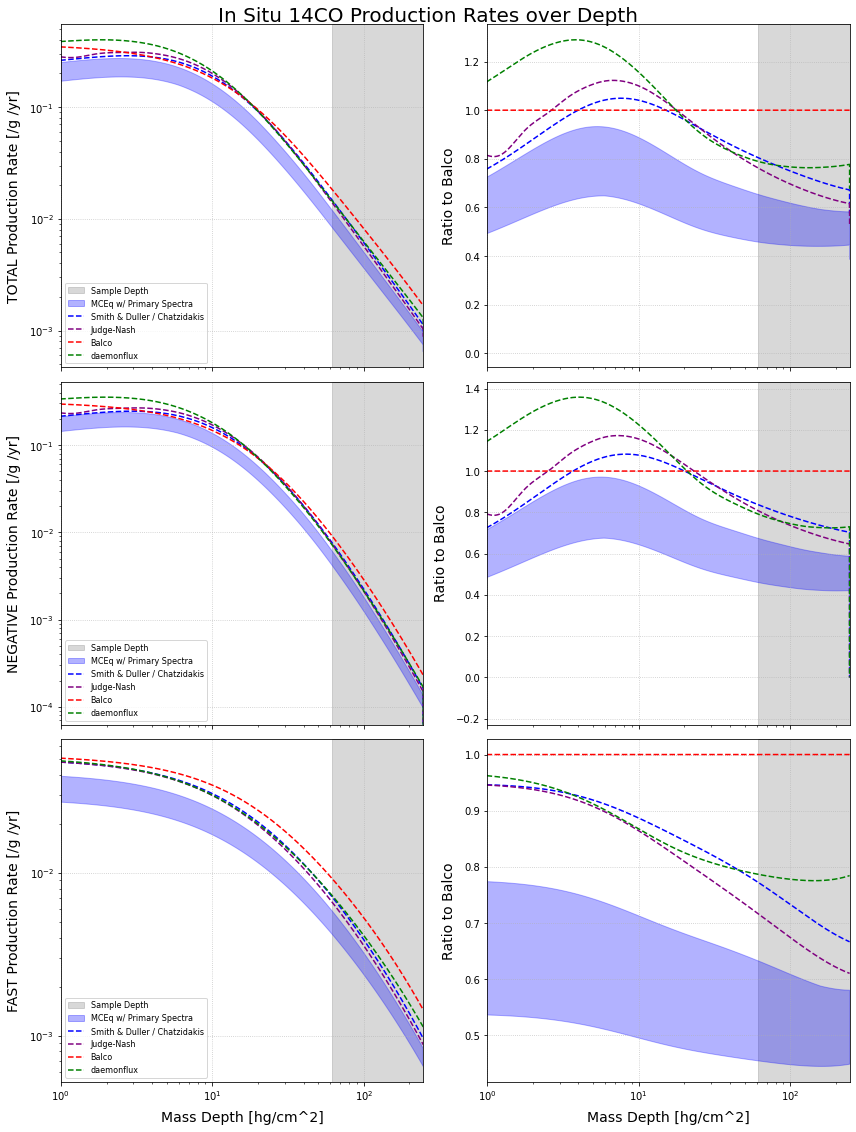

In [221]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2, figsize=(12,16), tight_layout=True, sharex=True)
ax1.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
ax2.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
ax3.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
ax4.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
ax5.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
ax6.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')

#for i in range(np.shape(P_Rates)[1]):
    #if i//5 == 0:
        #ls = '-'
    #elif i//5 == 1:
        #ls = '-.'
    #else:
        #ls = ':'
    #ax1.plot(h, P_Rates[0,i,0]*f_neg+P_Rates[1,i,0]*f_fast, ls=ls, label=model_names[i])
    #ax2.plot(h, (P_Rates[0,i,0]*f_neg+P_Rates[1,i,0]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), ls=ls, label=model_names[i])
    #ax3.plot(h, P_Rates[0,i,0]*f_neg, ls=ls, label=model_names[i])
    #ax4.plot(h, (P_Rates[0,i,0]*f_neg)/(P_pred[0]*f_neg), ls=ls, label=model_names[i])
    #ax5.plot(h, P_Rates[1,i,0]*f_fast, ls=ls, label=model_names[i])
    #ax6.plot(h, (P_Rates[1,i,0]*f_fast)/(P_pred[1]*f_fast), ls=ls, label=model_names[i])
ax1.fill_between(h, P_Rates_bot[0]*f_neg + P_Rates_bot[1]*f_fast, P_Rates_top[0]*f_neg + P_Rates_top[1]*f_fast, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax2.fill_between(h, (P_Rates_bot[0]*f_neg + P_Rates_bot[1]*f_fast)/(P_pred[0,:,0]*f_neg+P_pred[1,:,0]*f_fast), (P_Rates_top[0]*f_neg + P_Rates_top[1]*f_fast)/(P_pred[0,:,0]*f_neg+P_pred[1,:,0]*f_fast), color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax3.fill_between(h, P_Rates_bot[0]*f_neg, P_Rates_top[0]*f_neg, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax4.fill_between(h, P_Rates_bot[0]*f_neg/(P_pred[0,:,0]*f_neg), P_Rates_top[0]*f_neg/(P_pred[0,:,0]*f_neg), color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax5.fill_between(h, P_Rates_bot[1]*f_fast, P_Rates_top[1]*f_fast, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax6.fill_between(h, P_Rates_bot[1]*f_fast/(P_pred[1,:,0]*f_fast), P_Rates_top[1]*f_fast/(P_pred[1,:,0]*f_fast), color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')

ax1.plot(h, P_SDC[0]*f_neg+P_SDC[1]*f_fast, c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax1.plot(h, P_JN[0]*f_neg+P_JN[1]*f_fast, c='purple', ls='--', label='Judge-Nash')
ax1.plot(h, P_pred[0]*f_neg+P_pred[1]*f_fast, c='r', ls='--', label='Balco')
ax1.plot(h, P_df[0]*f_neg+P_df[1]*f_fast, c='g', ls='--', label='daemonflux')

ax2.plot(h, (P_SDC[0]*f_neg+P_SDC[1]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax2.plot(h, (P_JN[0]*f_neg+P_JN[1]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), c='purple', ls='--', label='Judge-Nash')
ax2.plot(h, (P_pred[0]*f_neg+P_pred[1]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), c='r', ls='--', label='Balco')
ax2.plot(h, (P_df[0]*f_neg+P_df[1]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), c='g', ls='--', label='daemonflux')

ax3.plot(h, P_SDC[0]*f_neg, c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax3.plot(h, P_JN[0]*f_neg, c='purple', ls='--', label='Judge-Nash')
ax3.plot(h, P_pred[0]*f_neg, c='r', ls='--', label='Balco')
ax3.plot(h, P_df[0]*f_neg, c='g', ls='--', label='daemonflux')

ax4.plot(h, (P_SDC[0]*f_neg)/(P_pred[0]*f_neg), c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax4.plot(h, (P_JN[0]*f_neg)/(P_pred[0]*f_neg), c='purple', ls='--', label='Judge-Nash')
ax4.plot(h, (P_pred[0]*f_neg)/(P_pred[0]*f_neg), c='r', ls='--', label='Balco')
ax4.plot(h, (P_df[0]*f_neg)/(P_pred[0]*f_neg), c='g', ls='--', label='daemonflux')

ax5.plot(h, P_SDC[1]*f_fast, c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax5.plot(h, P_JN[1]*f_fast, c='purple', ls='--', label='Judge-Nash')
ax5.plot(h, P_pred[1]*f_fast, c='r', ls='--', label='Balco')
ax5.plot(h, P_df[1]*f_fast, c='g', ls='--', label='daemonflux')

ax6.plot(h, (P_SDC[1]*f_fast)/(P_pred[1]*f_fast), c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax6.plot(h, (P_JN[1]*f_fast)/(P_pred[1]*f_fast), c='purple', ls='--', label='Judge-Nash')
ax6.plot(h, (P_pred[1]*f_fast)/(P_pred[1]*f_fast), c='r', ls='--', label='Balco')
ax6.plot(h, (P_df[1]*f_fast)/(P_pred[1]*f_fast), c='g', ls='--', label='daemonflux')

ax1.set(xlim = (1, h[-1]),
       xscale = 'log',
       yscale = 'log',
       ylabel='TOTAL Production Rate [/g /yr]')
ax1.legend(loc='best', fontsize=8)

ax2.set(xlim = (1, h[-1]),
       xscale = 'log',
       ylabel='Ratio to Balco')

ax3.set(xlim = (1, h[-1]),
       xscale = 'log',
       yscale = 'log',
       ylabel='NEGATIVE Production Rate [/g /yr]')
ax3.legend(loc='best', fontsize=8)

ax4.set(xlim = (1, h[-1]),
       xscale = 'log',
       ylabel='Ratio to Balco')

ax5.set(xlabel='Mass Depth [hg/cm^2]',
       xlim = (1, h[-1]),
       xscale = 'log',
       yscale = 'log',
       ylabel='FAST Production Rate [/g /yr]')
ax5.legend(loc='best', fontsize=8)

ax6.set(xlabel='Mass Depth [hg/cm^2]',
       xlim = (1, h[-1]),
       xscale = 'log',
       ylabel='Ratio to Balco')

fig.suptitle('In Situ 14CO Production Rates over Depth', size=20)

Text(0.5, 0.98, 'In Situ 14CO Production Rates over Depth')

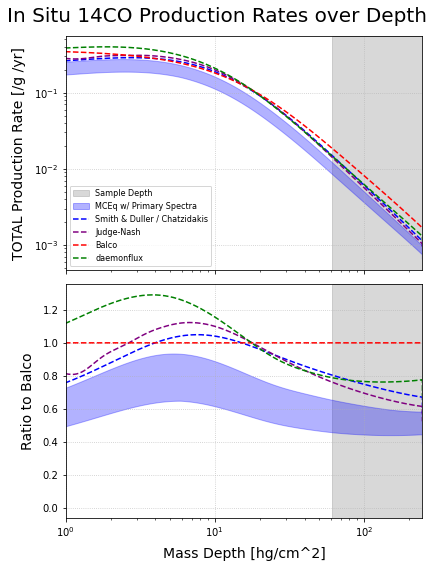

In [222]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6,8), tight_layout=True, sharex=True)
ax1.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
ax2.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')

#for i in range(np.shape(P_Rates)[1]):
    #if i//5 == 0:
        #ls = '-'
    #elif i//5 == 1:
        #ls = '-.'
    #else:
        #ls = ':'
    #ax1.plot(h, P_Rates[0,i,0]*f_neg+P_Rates[1,i,0]*f_fast, ls=ls, label=model_names[i])
    #ax2.plot(h, (P_Rates[0,i,0]*f_neg+P_Rates[1,i,0]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), ls=ls, label=model_names[i])
    #ax3.plot(h, P_Rates[0,i,0]*f_neg, ls=ls, label=model_names[i])
    #ax4.plot(h, (P_Rates[0,i,0]*f_neg)/(P_pred[0]*f_neg), ls=ls, label=model_names[i])
    #ax5.plot(h, P_Rates[1,i,0]*f_fast, ls=ls, label=model_names[i])
    #ax6.plot(h, (P_Rates[1,i,0]*f_fast)/(P_pred[1]*f_fast), ls=ls, label=model_names[i])
ax1.fill_between(h, P_Rates_bot[0]*f_neg + P_Rates_bot[1]*f_fast, P_Rates_top[0]*f_neg + P_Rates_top[1]*f_fast, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax2.fill_between(h, (P_Rates_bot[0]*f_neg + P_Rates_bot[1]*f_fast)/(P_pred[0,:,0]*f_neg+P_pred[1,:,0]*f_fast), (P_Rates_top[0]*f_neg + P_Rates_top[1]*f_fast)/(P_pred[0,:,0]*f_neg+P_pred[1,:,0]*f_fast), color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')

ax1.plot(h, P_SDC[0]*f_neg+P_SDC[1]*f_fast, c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax1.plot(h, P_JN[0]*f_neg+P_JN[1]*f_fast, c='purple', ls='--', label='Judge-Nash')
ax1.plot(h, P_pred[0]*f_neg+P_pred[1]*f_fast, c='r', ls='--', label='Balco')
ax1.plot(h, P_df[0]*f_neg+P_df[1]*f_fast, c='g', ls='--', label='daemonflux')

ax2.plot(h, (P_SDC[0]*f_neg+P_SDC[1]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax2.plot(h, (P_JN[0]*f_neg+P_JN[1]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), c='purple', ls='--', label='Judge-Nash')
ax2.plot(h, (P_pred[0]*f_neg+P_pred[1]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), c='r', ls='--', label='Balco')
ax2.plot(h, (P_df[0]*f_neg+P_df[1]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), c='g', ls='--', label='daemonflux')

ax1.set(xlim = (1, h[-1]),
       xscale = 'log',
       yscale = 'log',
       ylabel='TOTAL Production Rate [/g /yr]')
ax1.legend(loc='best', fontsize=8)

ax2.set(xlim = (1, h[-1]),
       xlabel='Mass Depth [hg/cm^2]',
       xscale = 'log',
       ylabel='Ratio to Balco')

fig.suptitle('In Situ 14CO Production Rates over Depth', size=20)

Text(0.5, 0.98, 'In Situ 14CO Production Rates over Depth')

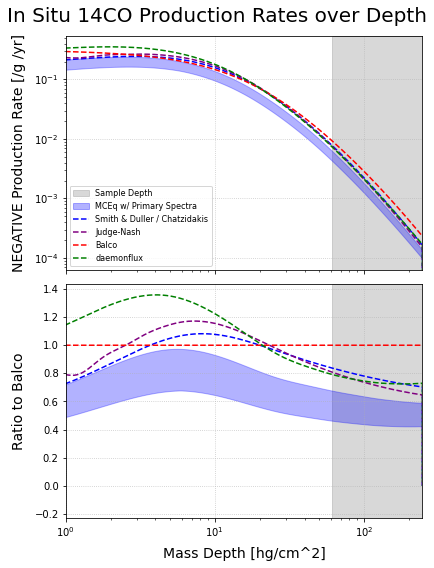

In [242]:
fig, (ax3,ax4) = plt.subplots(2,1, figsize=(6,8), tight_layout=True, sharex=True)
ax3.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
ax4.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')

#for i in range(np.shape(P_Rates)[1]):
    #if i//5 == 0:
        #ls = '-'
    #elif i//5 == 1:
        #ls = '-.'
    #else:
        #ls = ':'
    #ax1.plot(h, P_Rates[0,i,0]*f_neg+P_Rates[1,i,0]*f_fast, ls=ls, label=model_names[i])
    #ax2.plot(h, (P_Rates[0,i,0]*f_neg+P_Rates[1,i,0]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), ls=ls, label=model_names[i])
    #ax3.plot(h, P_Rates[0,i,0]*f_neg, ls=ls, label=model_names[i])
    #ax4.plot(h, (P_Rates[0,i,0]*f_neg)/(P_pred[0]*f_neg), ls=ls, label=model_names[i])
    #ax5.plot(h, P_Rates[1,i,0]*f_fast, ls=ls, label=model_names[i])
    #ax6.plot(h, (P_Rates[1,i,0]*f_fast)/(P_pred[1]*f_fast), ls=ls, label=model_names[i])
ax3.fill_between(h, P_Rates_bot[0]*f_neg, P_Rates_top[0]*f_neg, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax4.fill_between(h, P_Rates_bot[0]*f_neg/(P_pred[0,:,0]*f_neg), P_Rates_top[0]*f_neg/(P_pred[0,:,0]*f_neg), color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')

ax3.plot(h, P_SDC[0]*f_neg, c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax3.plot(h, P_JN[0]*f_neg, c='purple', ls='--', label='Judge-Nash')
ax3.plot(h, P_pred[0]*f_neg, c='r', ls='--', label='Balco')
ax3.plot(h, P_df[0]*f_neg, c='g', ls='--', label='daemonflux')

ax4.plot(h, (P_SDC[0]*f_neg)/(P_pred[0]*f_neg), c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax4.plot(h, (P_JN[0]*f_neg)/(P_pred[0]*f_neg), c='purple', ls='--', label='Judge-Nash')
ax4.plot(h, (P_pred[0]*f_neg)/(P_pred[0]*f_neg), c='r', ls='--', label='Balco')
ax4.plot(h, (P_df[0]*f_neg)/(P_pred[0]*f_neg), c='g', ls='--', label='daemonflux')

ax3.set(xlim = (1, h[-1]),
       xscale = 'log',
       yscale = 'log',
       ylabel='NEGATIVE Production Rate [/g /yr]')
ax3.legend(loc='best', fontsize=8)

ax4.set(xlim = (1, h[-1]),
       xlabel='Mass Depth [hg/cm^2]',
       xscale = 'log',
       ylabel='Ratio to Balco')

fig.suptitle('In Situ 14CO Production Rates over Depth', size=20)

Text(0.5, 0.98, 'In Situ 14CO Production Rates over Depth')

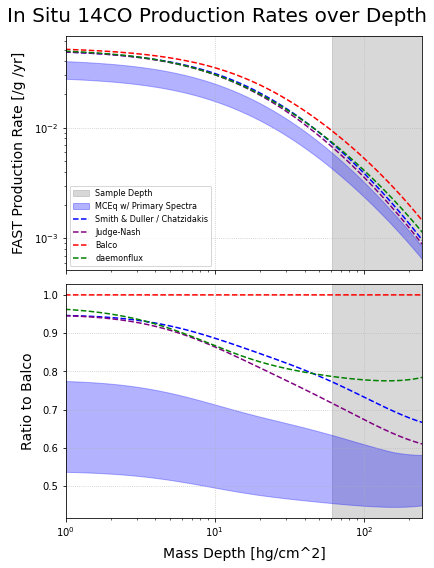

In [243]:
fig, (ax5,ax6) = plt.subplots(2,1, figsize=(6,8), tight_layout=True, sharex=True)
ax5.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
ax6.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')

#for i in range(np.shape(P_Rates)[1]):
    #if i//5 == 0:
        #ls = '-'
    #elif i//5 == 1:
        #ls = '-.'
    #else:
        #ls = ':'
    #ax1.plot(h, P_Rates[0,i,0]*f_neg+P_Rates[1,i,0]*f_fast, ls=ls, label=model_names[i])
    #ax2.plot(h, (P_Rates[0,i,0]*f_neg+P_Rates[1,i,0]*f_fast)/(P_pred[0]*f_neg+P_pred[1]*f_fast), ls=ls, label=model_names[i])
    #ax3.plot(h, P_Rates[0,i,0]*f_neg, ls=ls, label=model_names[i])
    #ax4.plot(h, (P_Rates[0,i,0]*f_neg)/(P_pred[0]*f_neg), ls=ls, label=model_names[i])
    #ax5.plot(h, P_Rates[1,i,0]*f_fast, ls=ls, label=model_names[i])
    #ax6.plot(h, (P_Rates[1,i,0]*f_fast)/(P_pred[1]*f_fast), ls=ls, label=model_names[i])
ax5.fill_between(h, P_Rates_bot[1]*f_fast, P_Rates_top[1]*f_fast, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax6.fill_between(h, P_Rates_bot[1]*f_fast/(P_pred[1,:,0]*f_fast), P_Rates_top[1]*f_fast/(P_pred[1,:,0]*f_fast), color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')

ax5.plot(h, P_SDC[1]*f_fast, c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax5.plot(h, P_JN[1]*f_fast, c='purple', ls='--', label='Judge-Nash')
ax5.plot(h, P_pred[1]*f_fast, c='r', ls='--', label='Balco')
ax5.plot(h, P_df[1]*f_fast, c='g', ls='--', label='daemonflux')

ax6.plot(h, (P_SDC[1]*f_fast)/(P_pred[1]*f_fast), c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax6.plot(h, (P_JN[1]*f_fast)/(P_pred[1]*f_fast), c='purple', ls='--', label='Judge-Nash')
ax6.plot(h, (P_pred[1]*f_fast)/(P_pred[1]*f_fast), c='r', ls='--', label='Balco')
ax6.plot(h, (P_df[1]*f_fast)/(P_pred[1]*f_fast), c='g', ls='--', label='daemonflux')

ax5.set(xlim = (1, h[-1]),
       xscale = 'log',
       yscale = 'log',
       ylabel='FAST Production Rate [/g /yr]')
ax5.legend(loc='best', fontsize=8)

ax6.set(xlabel='Mass Depth [hg/cm^2]',
       xlim = (1, h[-1]),
       xscale = 'log',
       ylabel='Ratio to Balco')

fig.suptitle('In Situ 14CO Production Rates over Depth', size=20)

## 14CO Profile Integration

In [225]:
def diag_sum(A, off=None, axis1=-2, axis2=-1):
    # sums along the upper diagonals of two axes in an array
    # the new axis replaces axis1; axis2 is eliminated.
    if off==None:
        off = np.flip(range(np.shape(A)[axis2]))
    return np.moveaxis(np.array([np.trace(A, offset=i, axis1=axis1, axis2=axis2) for i in off]), 0, axis1 if axis1>=0 else axis1+1)

In [226]:
lambda_dt = (1-lambd)**(t[i_int][-1]-t[i_int]) * dt

In [227]:
C_modes = diag_sum(P_Rates[:,:,:,i_int] * lambda_dt).swapaxes(0,-2)

In [228]:
F = np.array([[f_neg, f_fast]])

In [229]:
CO = F @ C_modes

In [230]:
C_pred = diag_sum(P_pred[:,i_int] * lambda_dt)
CO_pred = F @ C_pred

In [231]:
C_SDC = diag_sum(P_SDC[:,i_int] * lambda_dt)
CO_SDC = F @ C_SDC

In [232]:
C_JN = diag_sum(P_JN[:,i_int] * lambda_dt)
CO_JN = F @ C_JN

In [233]:
C_df = diag_sum(P_df[:,i_int] * lambda_dt)
CO_df = F @ C_df

In [234]:
t_scale = (t[i_int]-t[i_int][-1])/(t[i_int][-1]-t[i_int][0])

slope = 0.1
C_lin = diag_sum(P_pred[:,i_int] * lambda_dt * (1+slope*t_scale))
CO_lin = F @ C_lin

step_amp = 0.1
C_step = diag_sum(P_pred[:,i_int] * lambda_dt * (1+step_amp*(t_scale>-0.5))/(1+step_amp))
CO_step = F @ C_step

## 14CO Profile Plots

In [235]:
depth_avg = 20
z_bins = np.append(np.arange(z_start, z_deep, depth_avg), z_deep)
i_bins = np.argmin(abs(depths_real[i_int].reshape((-1,1))-z_bins.reshape((1,-1))), axis=0)
i_bins[-1] += 1

dh_core = np.zeros(len(i_bins)-1)
core_mat = np.zeros((len(i_int), len(i_bins)-1))
for i in range(len(i_bins)-1):
    dh_core[i] = np.sum(dh[i_int][i_bins[i]:i_bins[i+1]])
    core_mat[i_bins[i]:i_bins[i+1], i] = dh[i_int][i_bins[i]:i_bins[i+1]]/dh_core[i]

z_samp = z[i_int] @ core_mat

CO_core = CO @ core_mat

In [236]:
CO_top = np.max(CO, axis=(0,1,2))
CO_bot = np.min(CO, axis=(0,1,2))

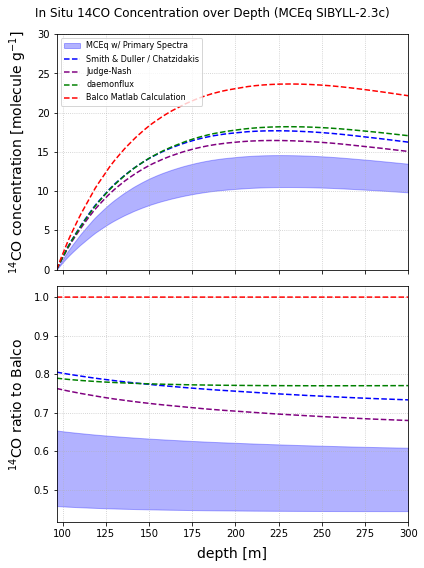

In [237]:
sample = False
change = False

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6,8), tight_layout=True, sharex=True)

if sample:
    for i in i_bins[1:-1]:
        ax1.axvline(z[i_int][i], c='black', ls='--', alpha=0.2) 
        ax2.axvline(z[i_int][i], c='black', ls='--', alpha=0.2) 

#for i,co_model in enumerate(CO):
    #for j,co in enumerate(co_model):
        #if j//5 == 0:
            #ls = '-'
        #elif j//5 == 1:
            #ls = '-.'
        #else:
            #ls = ':'
        #ax1.plot(z[i_int], co[0], ls=ls, label=model_names[j])
        #ax2.plot(z[i_int], co[0]/CO_pred[0], ls=ls, label=model_names[j])
        #if sample:
            #ax1.scatter(z_samp, CO_core[i,j,0])
            #ax2.scatter(z_samp, CO_core[i,j,0]/(CO_pred @ core_mat)[0])
ax1.fill_between(z[i_int], CO_bot, CO_top, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax2.fill_between(z[i_int], CO_bot/CO_pred[0], CO_top/CO_pred[0], color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')

ax1.plot(z[i_int], CO_SDC[0], c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax1.plot(z[i_int], CO_JN[0], c='purple', ls='--', label='Judge-Nash')
ax1.plot(z[i_int], CO_df[0], c='g', ls='--', label='daemonflux')
if change:
    ax1.plot(z[i_int], CO_lin[0], c='orange', ls='--', label='Balco Linear {:.1f}%'.format(slope*100))
    ax1.plot(z[i_int], CO_step[0], c='grey', ls='--', label='Balco Step {:.1f}%'.format(step_amp*100))
ax1.plot(z[i_int], CO_pred[0], c='r', ls='--', label='Balco Matlab Calculation')
if sample:
    ax1.scatter(z_samp, (CO_SDC@core_mat)[0], c='b')
    ax1.scatter(z_samp, (CO_JN@core_mat)[0], c='purple')
    ax1.scatter(z_samp, (CO_df@core_mat)[0], c='g')
    if change:
        ax1.scatter(z_samp, (CO_lin@core_mat)[0], c='orange')
        ax1.scatter(z_samp, (CO_step@core_mat)[0], c='grey')
    ax1.scatter(z_samp, (CO_pred@core_mat)[0], c='r')

ax2.plot(z[i_int], CO_SDC[0]/CO_pred[0], c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax2.plot(z[i_int], CO_JN[0]/CO_pred[0], c='purple', ls='--', label='Judge-Nash')
ax2.plot(z[i_int], CO_df[0]/CO_pred[0], c='g', ls='--', label='daemonflux')
if change:
    ax2.plot(z[i_int], CO_lin[0]/CO_pred[0], c='orange', ls='--', label='Balco Linear {:.1f}%'.format(slope*100))
    ax2.plot(z[i_int], CO_step[0]/CO_pred[0], c='grey', ls='--', label='Balco Step {:.1f}%'.format(step_amp*100))
ax2.plot(z[i_int], CO_pred[0]/CO_pred[0], c='r', ls='--', label='Balco Matlab Calculation')
if sample:
    ax2.scatter(z_samp, (CO_SDC@core_mat)[0] / (CO_pred@core_mat)[0], c='b')
    ax2.scatter(z_samp, (CO_JN@core_mat)[0] / (CO_pred@core_mat)[0], c='purple')
    ax2.scatter(z_samp, (CO_df@core_mat)[0] / (CO_pred@core_mat)[0], c='g')
    if change:
        ax2.scatter(z_samp, (CO_lin@core_mat)[0] / (CO_pred@core_mat)[0], c='orange')
        ax2.scatter(z_samp, (CO_step@core_mat)[0] / (CO_pred@core_mat)[0], c='grey')
    ax2.scatter(z_samp, (CO_pred@core_mat)[0] / (CO_pred@core_mat)[0], c='r')

ax1.set(#xlim=(z[i_int][0],z[i_int][-1]),
       #xlabel='depth [m]',
       ylim=(0,30),
       ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax1.legend(loc='upper left', fontsize=8)

ax2.set(xlim=(z[i_int][0],z[i_int][-1]),
       xlabel='depth [m]',
       #ylim=(0,40),
       ylabel=r'$^{14}$CO ratio to Balco')
#ax2.legend(loc='best', fontsize=10)

plt.suptitle('In Situ 14CO Concentration over Depth (MCEq {})'.format(interaction_model))
plt.show()

In [238]:
CO_norm_top = np.max(CO[0,:,0]/np.sum(CO[0,:]*dh[i_int], axis=-1), axis=0)
CO_norm_bot = np.min(CO[0,:,0]/np.sum(CO[0,:]*dh[i_int], axis=-1), axis=0)

In [239]:
CO_norm_top.shape

(7284,)

In [240]:
CO_norm_top

array([5.39563101e-06, 1.07864938e-05, 1.61725941e-05, ...,
       6.08989981e-03, 6.08962951e-03, 6.08929799e-03])

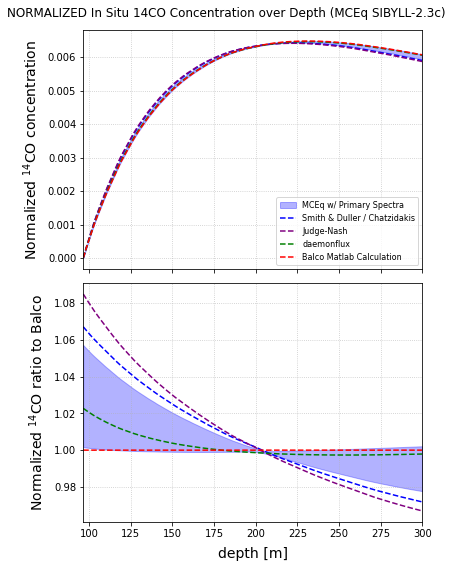

In [241]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8), tight_layout=True, sharex=True)

if sample:
    for i in i_bins[1:-1]:
        ax1.axvline(z[i_int][i], c='black', ls='--', alpha=0.2) 
        ax2.axvline(z[i_int][i], c='black', ls='--', alpha=0.2) 

#for i,co_model in enumerate(CO):
    #for j,co in enumerate(co_model):
        #if j//5 == 0:
            #ls = '-'
        #elif j//5 == 1:
            #ls = '-.'
        #else:
            #ls = ':'
        #ax1.plot(z[i_int], co[0]/np.sum(co*dh[i_int]), ls=ls, label=model_names[j])
        #ax2.plot(z[i_int], co[0]/np.sum(co*dh[i_int])*np.sum(CO_pred*dh[i_int])/CO_pred[0], ls=ls, label=model_names[j])
        #if sample:
            #ax1.scatter(z_samp, CO_core[i,j,0]/(CO_core[i,j,0]@dh_core))
            #ax2.scatter(z_samp, CO_core[i,j,0]/(CO_core[i,j,0]@dh_core) * ((CO_pred@core_mat)[0] @ dh_core) / (CO_pred@core_mat)[0])
ax1.fill_between(z[i_int], CO_norm_bot, CO_norm_top, color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
ax2.fill_between(z[i_int], CO_norm_bot*np.sum(CO_pred*dh[i_int])/CO_pred[0], CO_norm_top*np.sum(CO_pred*dh[i_int])/CO_pred[0], color='blue', alpha=0.3, label='MCEq w/ Primary Spectra')
            
ax1.plot(z[i_int], CO_SDC[0]/np.sum(CO_SDC*dh[i_int]), c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax1.plot(z[i_int], CO_JN[0]/np.sum(CO_JN*dh[i_int]), c='purple', ls='--', label='Judge-Nash')
ax1.plot(z[i_int], CO_df[0]/np.sum(CO_df*dh[i_int]), c='g', ls='--', label='daemonflux')
if change:
    ax1.plot(z[i_int], CO_lin[0]/np.sum(CO_lin*dh[i_int]), c='orange', ls='--', label='Balco Linear {:.1f}%'.format(slope*100))
    ax1.plot(z[i_int], CO_step[0]/np.sum(CO_step*dh[i_int]), c='grey', ls='--', label='Balco Step {:.1f}%'.format(step_amp*100))
ax1.plot(z[i_int], CO_pred[0]/np.sum(CO_pred*dh[i_int]), c='r', ls='--', label='Balco Matlab Calculation')
if sample:
    ax1.scatter(z_samp, (CO_SDC@core_mat)[0] / ((CO_SDC@core_mat)[0] @ dh_core), c='b')
    ax1.scatter(z_samp, (CO_JN@core_mat)[0] / ((CO_JN@core_mat)[0] @ dh_core), c='Judge-Nash')
    ax1.scatter(z_samp, (CO_df@core_mat)[0] / ((CO_df@core_mat)[0] @ dh_core), c='g')
    if change:
        ax1.scatter(z_samp, (CO_lin@core_mat)[0] / ((CO_lin@core_mat)[0] @ dh_core), c='orange')
        ax1.scatter(z_samp, (CO_step@core_mat)[0] / ((CO_step@core_mat)[0] @ dh_core), c='grey')
    ax1.scatter(z_samp, (CO_pred@core_mat)[0] / ((CO_pred@core_mat)[0] @ dh_core), c='r')

ax2.plot(z[i_int], CO_SDC[0]/np.sum(CO_SDC*dh[i_int])*np.sum(CO_pred*dh[i_int])/CO_pred[0], c='b', ls='--', label='Smith & Duller / Chatzidakis')
ax2.plot(z[i_int], CO_JN[0]/np.sum(CO_JN*dh[i_int])*np.sum(CO_pred*dh[i_int])/CO_pred[0], c='purple', ls='--', label='Judge-Nash')
ax2.plot(z[i_int], CO_df[0]/np.sum(CO_df*dh[i_int])*np.sum(CO_pred*dh[i_int])/CO_pred[0], c='g', ls='--', label='daemonflux')
if change:
    ax2.plot(z[i_int], CO_lin[0]/np.sum(CO_lin*dh[i_int])*np.sum(CO_pred*dh[i_int])/CO_pred[0], c='orange', ls='--', label='Balco Linear {:.1f}%'.format(slope*100))
    ax2.plot(z[i_int], CO_step[0]/np.sum(CO_step*dh[i_int])*np.sum(CO_pred*dh[i_int])/CO_pred[0], c='grey', ls='--', label='Balco Step {:.1f}%'.format(step_amp*100))
ax2.plot(z[i_int], CO_pred[0]/CO_pred[0], c='r', ls='--', label='Balco Matlab Calculation')
if sample:
    ax2.scatter(z_samp, (CO_SDC@core_mat)[0] / ((CO_SDC@core_mat)[0] @ dh_core) * ((CO_pred@core_mat)[0] @ dh_core) / (CO_pred@core_mat)[0], c='b')
    ax2.scatter(z_samp, (CO_JN@core_mat)[0] / ((CO_JN@core_mat)[0] @ dh_core) * ((CO_pred@core_mat)[0] @ dh_core) / (CO_pred@core_mat)[0], c='purple')
    ax2.scatter(z_samp, (CO_df@core_mat)[0] / ((CO_df@core_mat)[0] @ dh_core) * ((CO_pred@core_mat)[0] @ dh_core) / (CO_pred@core_mat)[0], c='g')
    if change:
        ax2.scatter(z_samp, (CO_lin@core_mat)[0] / ((CO_lin@core_mat)[0] @ dh_core) * ((CO_pred@core_mat)[0] @ dh_core) / (CO_pred@core_mat)[0], c='orange')
        ax2.scatter(z_samp, (CO_step@core_mat)[0] / ((CO_step@core_mat)[0] @ dh_core) * ((CO_pred@core_mat)[0] @ dh_core) / (CO_pred@core_mat)[0], c='grey')
    ax2.scatter(z_samp, (CO_pred@core_mat)[0] / (CO_pred@core_mat)[0], c='r')

ax1.set(#xlim=(z[i_int][0],z[i_int][-1]),
       #xlabel='depth [m]',
       #ylim=(0,40),
       ylabel=r'Normalized $^{14}$CO concentration')
ax1.legend(loc='best', fontsize=8)

ax2.set(xlim=(z[i_int][0],z[i_int][-1]),
       xlabel='depth [m]',
       #ylim=(0,40),
       ylabel=r'Normalized $^{14}$CO ratio to Balco')
#ax2.legend(loc='upper left', fontsize=14)

plt.suptitle('NORMALIZED In Situ 14CO Concentration over Depth (MCEq {})'.format(interaction_model))
plt.show()

In [97]:
cth = np.arange(1,0,-0.05)

In [98]:
pJN = judge_nash(E_flux, cth)

C:\Users\walte\AppData\Local\Temp/ipykernel_3252/4125256535.py:38: RuntimeWarning: invalid value encountered in power
  W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))


In [99]:
pJN.shape

(121, 20)

In [100]:
np.sum(np.sum(pJN*0.05, axis=1)*mceq._energy_grid.w)

0.0030017000545130264